In [1]:
import numpy as np
import os
import io
import tensorflow as tf
import pandas as pd
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
import random
import itertools
from scipy import stats
from skimage.transform import rotate
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Data Loading

In [50]:
region = 'WesternAsia'
data_dir = 'satellite/tf_records_100/' + region + '/'
IM_SIZE = 100
SHARD_SIZE = 20

In [51]:
featdef = {
    'image/height': tf.FixedLenFeature(shape=[], dtype=tf.int64),
    'image/width': tf.FixedLenFeature(shape=[], dtype=tf.int64),
    'image/filename': tf.FixedLenFeature(shape=[], dtype=tf.string),
    'image/encoded': tf.FixedLenFeature(shape=[], dtype=tf.string),
    'image/format': tf.FixedLenFeature(shape=[], dtype=tf.string),
    'image/object/corners/x': tf.VarLenFeature(dtype=tf.int64),
    'image/object/corners/y': tf.VarLenFeature(dtype=tf.int64),
    'image/object/point/x': tf.VarLenFeature(dtype=tf.int64),
    'image/object/point/y': tf.VarLenFeature(dtype=tf.int64),
    'image/object/class/text': tf.VarLenFeature(dtype=tf.string),
    'image/object/min_lat': tf.VarLenFeature(dtype=tf.float32),
    'image/object/min_lon': tf.VarLenFeature(dtype=tf.float32),
    'image/object/max_lat': tf.VarLenFeature(dtype=tf.float32),
    'image/object/max_lon': tf.VarLenFeature(dtype=tf.float32)
}

In [52]:
# Check TFRecord to make sure it's not garbage
def check_tf_records(files):
    for file in files:
        for example in tf.python_io.tf_record_iterator(file):
            result = tf.train.Example.FromString(example)
            image_data = result.features.feature['image/encoded'].bytes_list.value[0]
            im = np.frombuffer(image_data, dtype=np.uint8)
            im = np.reshape(im, (IM_SIZE, IM_SIZE, 3))
            shape = np.array(im).shape
            plt.imshow(im)
            plt.show()
            assert shape[0] > 0
            assert shape[1] > 0
            assert shape[-1] == 3

In [54]:
def _debug(example_proto):
    return example_proto, 1.

In [55]:
def test_random_img(files, N=4):
    ds = tf.data.TFRecordDataset(files).map(_debug).map(_parse_record)
    ds = ds.shuffle(buffer_size=256).batch(N)
    iterator = ds.make_one_shot_iterator()
    next_element = iterator.get_next()
    fig=plt.figure(figsize=(N*4, 2*4))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        images, y = sess.run(next_element)
        grid_points_maps, labels = y[0], y[1]
        for i in range(N):
            ax = fig.add_subplot(2, N, i+1)
            ax.set_title('Original: {0:0.02f}'.format(labels[i,0]))
            plt.imshow(images[i]/255.)
            ax = fig.add_subplot(2, N, N+i+1)
            plt.imshow(grid_points_maps[i])
        plt.show()

In [56]:
tfrecords = {}
for split in ['train', 'val', 'test']:
    tfrecords[split] = ['{}{}.tfrecord-0000{}-of-00010'.format(data_dir, split, i) for i in range(10)]

In [57]:
def _normalize(x, y):
    return tf.scalar_mul(1/128.0, tf.subtract(x,128)), y

In [58]:
def _parse_record(example_proto, debug=None):
    """Parse a single record into image, count labels"""
    example = tf.parse_single_example(example_proto, featdef)
    im = tf.decode_raw(example['image/encoded'], tf.uint8)
    im = tf.cast(im, dtype=tf.float32)
    im = tf.reshape(im, (IM_SIZE, IM_SIZE, 3))
    
    xcorners = tf.cast(example['image/object/corners/x'].values, dtype=tf.float32)
    ycorners = tf.cast(example['image/object/corners/y'].values, dtype=tf.float32)
    
    points = tf.cast(tf.stack([ycorners, xcorners], axis=1), tf.int64)
    points = tf.clip_by_value(points, 0, IM_SIZE-1)
    points = tf.SparseTensor(indices=points,
                           values=tf.cast(tf.ones_like(xcorners), tf.float32),
                           dense_shape=[IM_SIZE, IM_SIZE])
    points_map = tf.sparse_tensor_to_dense(points, validate_indices=False)
    points_map = tf.reshape(points_map, (IM_SIZE, IM_SIZE, 1))

    xpoints = tf.cast(example['image/object/point/x'].values, dtype=tf.float32)
    count = tf.reshape(tf.cast(tf.size(xpoints), tf.float32), (-1,))
    
    grid_size = IM_SIZE // SHARD_SIZE
    
    patches = tf.reshape(points_map, (grid_size, SHARD_SIZE, grid_size, SHARD_SIZE))
    patches = tf.transpose(patches, [0, 2, 1, 3])
    patches = tf.reshape(patches, (grid_size, grid_size, SHARD_SIZE*SHARD_SIZE))
    maxs = tf.reduce_max(patches, axis=2)
    maxs = tf.cast(tf.reshape(maxs, (grid_size, grid_size)), tf.bool)

    points_map = tf.reshape(points_map, (IM_SIZE, IM_SIZE))
    
    return im, (maxs, count)

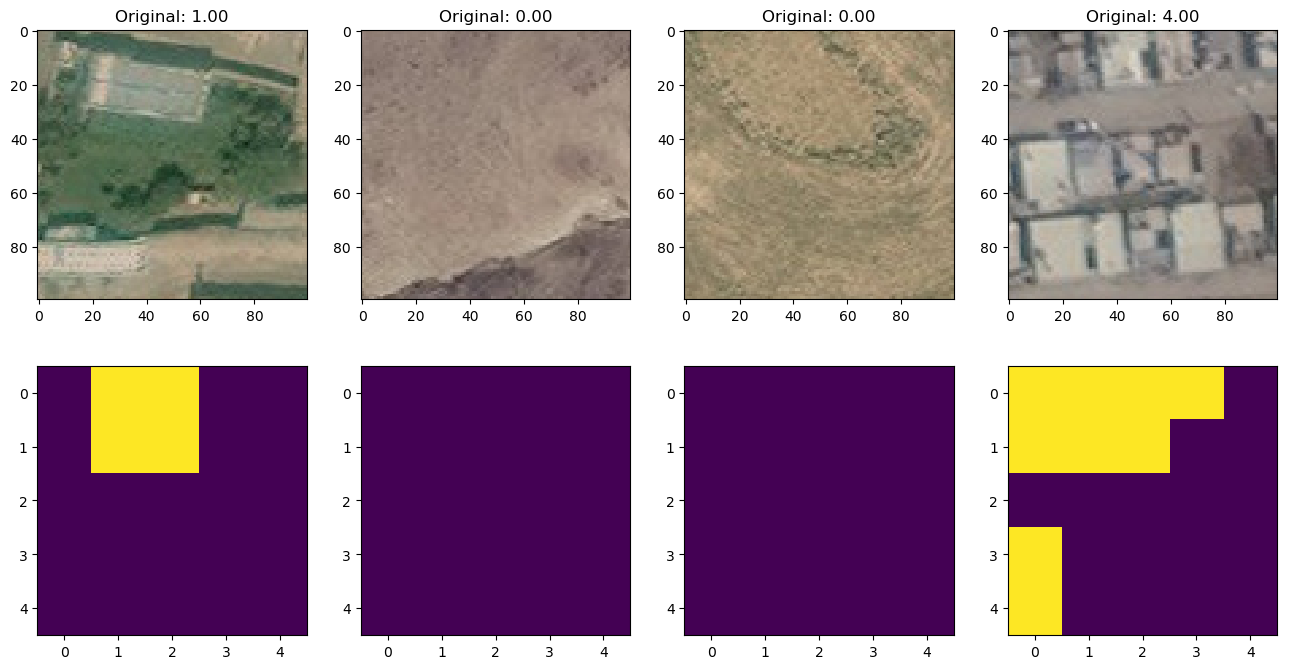

In [63]:
test_random_img(tfrecords['train'])

In [60]:
t = 0
for fn in tfrecords['train']:
  for record in tf.python_io.tf_record_iterator(fn):
     t += 1
print(t)

v = 0
for fn in tfrecords['val']:
  for record in tf.python_io.tf_record_iterator(fn):
     v += 1
print(v)

f = 0
for fn in tfrecords['test']:
  for record in tf.python_io.tf_record_iterator(fn):
     f += 1
print(f)

3555
490
650


# CNN

In [64]:
NUM_EPOCHS = 20
BATCH_SZ = 32

ds_train = tf.data.TFRecordDataset(tfrecords['train']).map(_parse_record).map(_normalize)
ds_train = ds_train.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)
ds_train = ds_train.repeat(NUM_EPOCHS)#.map(_augment)

ds_val = tf.data.TFRecordDataset(tfrecords['val']).map(_parse_record).map(_normalize)
ds_val = ds_val.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)
ds_val = ds_val.repeat(NUM_EPOCHS)

In [65]:
def CNN_model():
    image_input = tf.keras.Input(shape=(IM_SIZE, IM_SIZE, 3), name='image_input')
    
    patches_1 = tf.keras.layers.Reshape((IM_SIZE // SHARD_SIZE, 
                                               SHARD_SIZE, 
                                               IM_SIZE // SHARD_SIZE, 
                                               SHARD_SIZE, 
                                               3))(image_input)
    
    patches_2 = tf.keras.layers.Permute((1, 3, 2, 4, 5))(patches_1)
    
    patches_3 = tf.keras.layers.Reshape(((IM_SIZE**2)//(SHARD_SIZE**2), 
                                                SHARD_SIZE, 
                                                SHARD_SIZE, 
                                                3))(patches_2)
    
    conv_1 = tf.keras.layers.Conv3D(32, kernel_size=(1, 3, 3),
                 activation='relu',
                 padding='same')(patches_3)
    maxpool_1 = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(conv_1)
    conv_2 = tf.keras.layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(maxpool_1)
    maxpool_2 = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(conv_2)
    conv_3 = tf.keras.layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(maxpool_2)
    maxpool_3 = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(conv_3)
    conv_4 = tf.keras.layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(maxpool_3)
    maxpool_4 = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(conv_4)
    
    drop_1 = tf.keras.layers.Dropout(0.25)(maxpool_4)
    flat_1 = tf.keras.layers.Flatten()(drop_1)
    flat_1 = tf.keras.layers.Reshape(((IM_SIZE**2)//(SHARD_SIZE**2), 64))(drop_1)
    dense_1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)(flat_1)
    drop_2 = tf.keras.layers.Dropout(0.5)(dense_1)
    region_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(drop_2)
    
    region_preds = tf.keras.layers.Reshape((IM_SIZE//SHARD_SIZE, IM_SIZE//SHARD_SIZE), name='map_out')(region_pred)
    
    drop_2_rs = tf.keras.layers.Reshape((IM_SIZE//SHARD_SIZE * IM_SIZE//SHARD_SIZE * 256,))(drop_2)
    count = tf.keras.layers.Dense(1, activation=tf.nn.relu, name='count_out')(drop_2_rs)

    return tf.keras.Model(inputs=image_input, outputs=[region_preds, count])

In [66]:
model = CNN_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 5, 20, 5, 20, 0           image_input[0][0]                
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 5, 5, 20, 20, 0           reshape_4[0][0]                  
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 25, 20, 20, 3 0           permute_1[0][0]                  
__________________________________________________________________________________________________
conv3d_4 (

In [67]:
losses = {'map_out' : 'binary_crossentropy',
          'count_out' : 'mse'}
lossWeights = {'map_out' : 1,
          'count_out' : 0.1}
metrics = {'map_out' : 'accuracy'}

model.compile(loss = losses, 
              loss_weights = lossWeights,
              optimizer = tf.keras.optimizers.Adadelta(), 
              metrics = metrics)

In [68]:
history = model.fit(ds_train, steps_per_epoch= int(t/BATCH_SZ), epochs=NUM_EPOCHS, 
                    validation_data=ds_val, validation_steps= int(v/BATCH_SZ),
                    callbacks= [tf.keras.callbacks.ModelCheckpoint(region + '_best_model_weights_120318.h5', 
                                                                monitor='val_loss', 
                                                                verbose=0, 
                                                                save_best_only=True, 
                                                                save_weights_only=True, 
                                                                mode='auto', 
                                                                period=1)]
                    )
model.save_weights(region + '_final_model_weights_120318.h5')

Epoch 1/20
111/111 [==============================] - 12s 110ms/step - loss: 3.9682 - map_out_loss: 0.4377 - count_out_loss: 35.3045 - map_out_acc: 0.8088 - val_loss: 2.4164 - val_map_out_loss: 0.6326 - val_count_out_loss: 17.8385 - val_map_out_acc: 0.4632
Epoch 2/20
111/111 [==============================] - 7s 64ms/step - loss: 2.2308 - map_out_loss: 0.3089 - count_out_loss: 19.2189 - map_out_acc: 0.8623 - val_loss: 2.2681 - val_map_out_loss: 0.5890 - val_count_out_loss: 16.7911 - val_map_out_acc: 0.5608
Epoch 3/20
111/111 [==============================] - 7s 62ms/step - loss: 1.9419 - map_out_loss: 0.2931 - count_out_loss: 16.4880 - map_out_acc: 0.8753 - val_loss: 2.8505 - val_map_out_loss: 0.6166 - val_count_out_loss: 22.3392 - val_map_out_acc: 0.5249
Epoch 4/20
111/111 [==============================] - 7s 62ms/step - loss: 1.7557 - map_out_loss: 0.2953 - count_out_loss: 14.6045 - map_out_acc: 0.8740 - val_loss: 2.9285 - val_map_out_loss: 0.6151 - val_count_out_loss: 23.1337 - va

In [69]:
model.load_weights(region + '_best_model_weights_120318.h5')

In [70]:
def get_groundtruth(ds, num_elems):
    iterator = ds.make_one_shot_iterator()
    next_element = iterator.get_next()
    images = []
    map_trues = []
    count_trues = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        while len(count_trues) < num_elems:
            x, y = sess.run(next_element)
            (map_true, count_true) = y
            images.extend(x)
            map_trues.extend(list(map_true))
            count_trues.extend(list(count_true.flatten()))
    return images, map_trues, count_trues

In [71]:
def get_cm(map_trues, map_preds):
    y_true = np.array(map_trues).flatten()
    y_pred = np.array(map_preds).flatten() > 0.5
    
    cm = confusion_matrix(y_true, y_pred)
    prec = cm[1,1]/(cm[1,1] + cm[0,1])
    recall = cm[1,1]/(cm[1,1] + cm[1,0])
    print('precision:', prec)
    print('recall:', recall)
    print('f1:', 2*prec*recall/(prec+recall))

    classes = [True, False]
    
    plt.figure()
    
    # Take out any labels that are not present in either y_true nor y_pred
    classes = [c for c in classes if c in y_pred or c in y_true]
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Model')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], '.2f'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    return cm

In [72]:
ds_train = tf.data.TFRecordDataset(tfrecords['train']).map(_parse_record).map(_normalize)
ds_train = ds_train.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

train_map_preds, train_count_preds = model.predict(ds_train, steps=int(t/BATCH_SZ))

ds_train = tf.data.TFRecordDataset(tfrecords['train']).map(_parse_record).map(_normalize)
ds_train = ds_train.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

train_images, train_map_trues, train_count_trues = get_groundtruth(ds_train, len(train_count_preds))

In [73]:
ds_val = tf.data.TFRecordDataset(tfrecords['val']).map(_parse_record).map(_normalize)
ds_val = ds_val.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

val_map_preds, val_count_preds = model.predict(ds_val, steps=int(v/BATCH_SZ))

ds_val = tf.data.TFRecordDataset(tfrecords['val']).map(_parse_record).map(_normalize)
ds_val = ds_val.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

val_images, val_map_trues, val_count_trues = get_groundtruth(ds_val, len(val_count_preds))

In [74]:
ds_test = tf.data.TFRecordDataset(tfrecords['test']).map(_parse_record).map(_normalize)
ds_test = ds_test.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

test_map_preds, test_count_preds = model.predict(ds_test, steps=int(f/BATCH_SZ))

ds_test = tf.data.TFRecordDataset(tfrecords['test']).map(_debug).map(_parse_record).map(_normalize)
ds_test = ds_test.shuffle(buffer_size=256, seed=325).batch(BATCH_SZ)

test_images, test_map_trues, test_count_trues = get_groundtruth(ds_test, len(test_count_preds))

In [75]:
train_count_trues = np.array(train_count_trues).flatten()
train_count_preds = np.array(train_count_preds).flatten()
val_count_trues = np.array(val_count_trues).flatten()
val_count_preds = np.array(val_count_preds).flatten()
test_count_trues = np.array(test_count_trues).flatten()
test_count_preds = np.array(test_count_preds).flatten()

In [76]:
def rmse(pred, true):
    return np.sqrt(np.mean((pred-true)**2))

In [77]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

In [78]:
def fancy_plot(x, y, title, xlabel, ylabel, boxtext):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(x, y, 'k.')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    all_max = np.maximum(np.max(train_count_trues), np.max(train_count_preds))
    ax.text(all_max*0.6, all_max*0.95, boxtext,
            verticalalignment='top')

    ax.set_xlim(0, all_max)
    ax.set_ylim(0, all_max)
    plt.show()

In [79]:
# unused here, but a more useful function than fancy_plot
def show_correlations(x, y, title, xlabel, ylabel, text=(0.07, 0.97)):
    from scipy.stats import linregress

    fig, axes = plt.subplots(1, 1, figsize=(4.3, 4))
    all_max = int(np.max([np.max(x), np.max(y)])) + 1
    xrange=np.asarray([0, all_max])

    reg = linregress(x, y)
    rmse_xy = rmse(x, y)
    axes.plot(x, y, 'k.')
    axes.plot(xrange, xrange*reg.slope + reg.intercept, 'r-')
    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(0, all_max)
    axes.set_ylim(0, all_max)
    axes.text(all_max*text[0], all_max*text[1], '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(reg.rvalue*reg.rvalue, rmse_xy),
               verticalalignment='top')
  
    plt.show()

# Africa2 Results

In [113]:
print(list(test_count_preds[:300]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30025163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14820743, 0.0, 0.7169358, 0.0, 0.0, 0.06620273, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23114373, 0.47638175, 0.19003224, 0.0, 0.0, 0.0, 0.19770232, 0.5955382, 0.0, 0.0, 0.02001658, 0.0, 0.0, 0.044961274, 0.03932789, 0.0, 0.043860525, 0.13838905, 0.0, 1.0700989, 0.0013549626, 0.5068799, 0.0, 0.035234004, 0.13964587, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.68275964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11503452, 0.0, 0.0, 0.312461, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22571087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57109815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.72306854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29527473, 0.0392977, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

precision: 0.6534597424649781
recall: 0.0636451966344398
f1: 0.1159929921947115


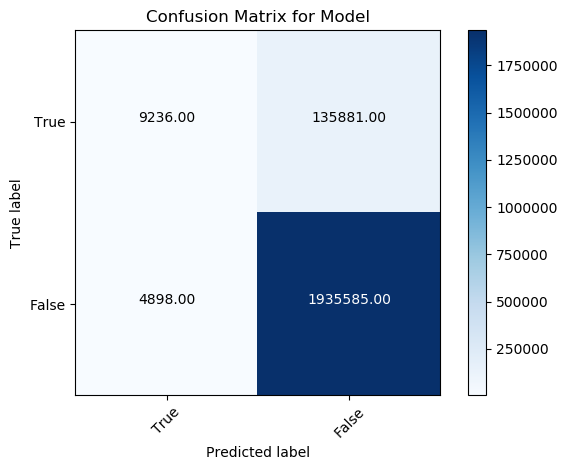

precision: 0.263103802672148
recall: 0.00871014936545201
f1: 0.0168620735081017


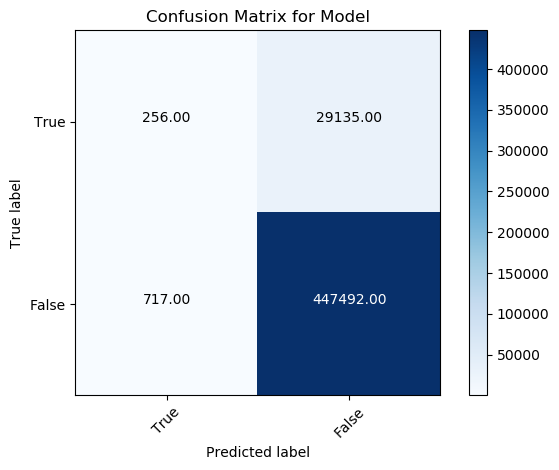

precision: 0.323943661971831
recall: 0.000999869582228405
f1: 0.0019935858542082


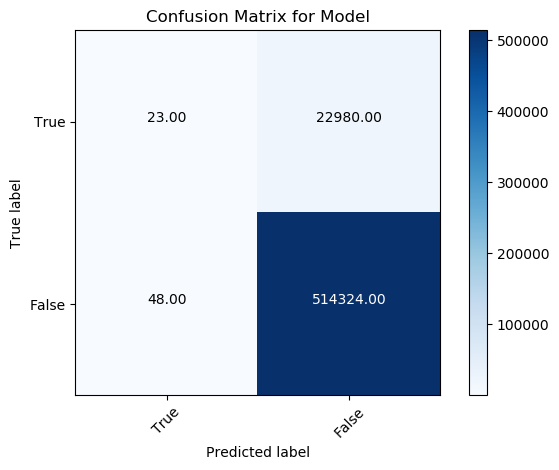

array([[    23,  22980],
       [    48, 514324]])

In [48]:
get_cm(train_map_trues, train_map_preds)
get_cm(val_map_trues, val_map_preds)
get_cm(test_map_trues, test_map_preds)

In [34]:
gt_test = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 3.0, 0.0, 1.0, 12.0, 2.0, 9.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 3.0, 3.0, 19.0, 9.0, 0.0, 1.0, 0.0, 3.0, 4.0, 0.0, 0.0, 5.0, 0.0, 1.0, 1.0, 4.0, 6.0, 0.0, 0.0, 3.0, 8.0, 6.0, 9.0, 0.0, 5.0, 5.0, 1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 5.0, 7.0, 10.0, 0.0, 5.0, 0.0, 0.0, 8.0, 1.0, 0.0, 2.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 1.0, 0.0, 0.0, 5.0, 4.0, 2.0, 6.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 14.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 6.0, 0.0, 2.0, 5.0, 0.0, 0.0, 0.0, 2.0, 0.0, 6.0, 1.0, 7.0, 0.0, 3.0, 0.0, 7.0, 0.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 10.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, 2.0, 5.0, 0.0, 4.0, 0.0, 10.0, 3.0, 5.0, 1.0, 1.0, 1.0, 6.0, 1.0, 7.0, 4.0, 1.0, 0.0, 0.0, 14.0, 6.0, 11.0, 11.0, 6.0, 0.0, 4.0, 0.0, 0.0, 0.0, 5.0, 0.0, 8.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 3.0, 4.0, 19.0, 0.0, 0.0, 4.0, 1.0, 0.0, 5.0, 0.0, 0.0, 32.0, 0.0, 3.0, 7.0, 1.0, 8.0, 0.0, 3.0, 1.0, 2.0, 0.0, 5.0, 7.0, 2.0, 7.0, 0.0, 2.0, 0.0, 18.0, 0.0, 3.0, 0.0, 0.0, 0.0, 9.0, 6.0, 0.0, 0.0, 6.0, 3.0, 2.0, 0.0, 13.0, 0.0, 0.0, 4.0, 0.0, 7.0, 3.0, 0.0, 7.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 4.0, 0.0, 0.0, 9.0, 0.0, 5.0, 7.0]

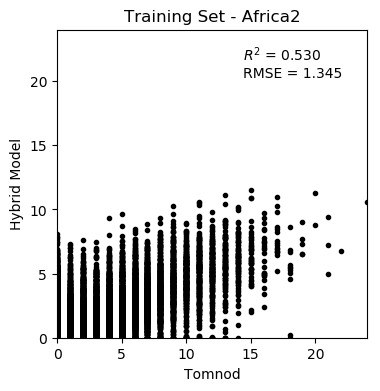

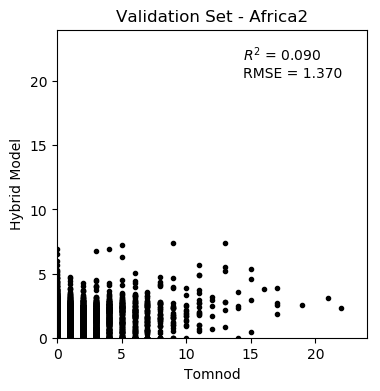

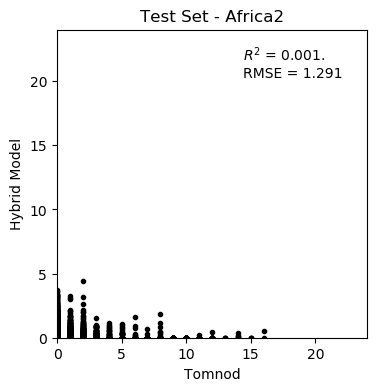

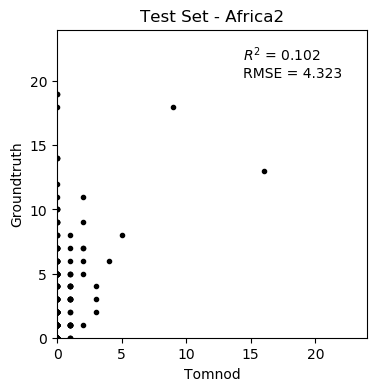

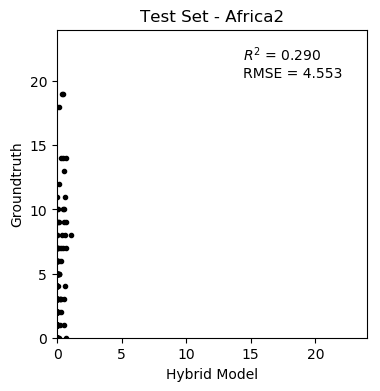

In [52]:
mt, bt, rt, pt, et = stats.linregress(train_count_trues, train_count_preds)
rmse_train = rmse(train_count_trues, train_count_preds)

mv, bv, rv, pv, ev = stats.linregress(val_count_trues, val_count_preds)
rmse_val = rmse(val_count_trues, val_count_preds)

mv, bv, rtest, pv, ev = stats.linregress(test_count_trues, test_count_preds)
rmse_test = rmse(test_count_trues, test_count_preds)

mf, bf, rf, pf, ef = stats.linregress(test_count_trues[:300], gt_test)
rmse_test_cs = rmse(test_count_trues[:300], gt_test)

mf, bf, rm, pf, ef = stats.linregress(test_count_preds[:300], gt_test)
rmse_test_mod = rmse(test_count_preds[:300], gt_test)


fancy_plot(train_count_trues, train_count_preds, 
           'Training Set - Africa2', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rt**2, rmse_train))

fancy_plot(val_count_trues, val_count_preds, 
           'Validation Set - Africa2', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rv**2, rmse_val))

fancy_plot(test_count_trues, test_count_preds, 
           'Test Set - Africa2', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(rtest**2, rmse_test))

fancy_plot(test_count_trues[:300], gt_test,
          'Test Set - Africa2', 'Tomnod', 'Groundtruth',
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rf**2, rmse_test_cs))

fancy_plot(test_count_preds[:300], gt_test,
          'Test Set - Africa2', 'Hybrid Model', 'Groundtruth',
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rm**2, rmse_test_mod))

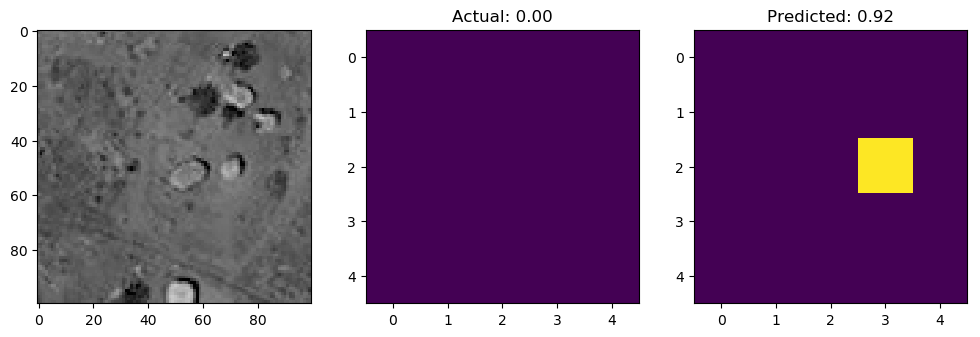

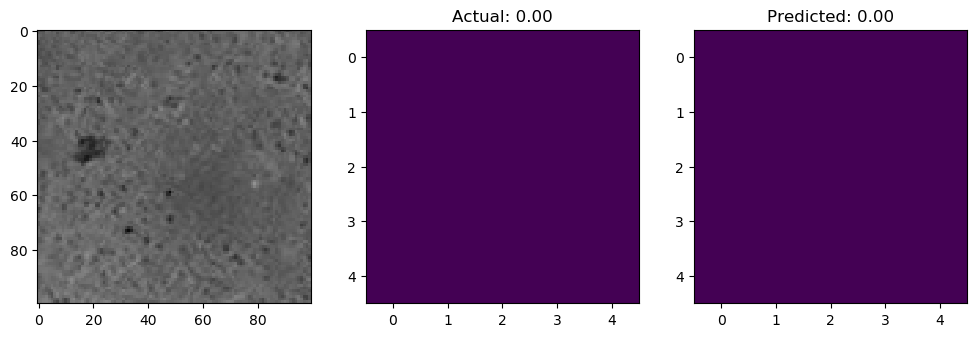

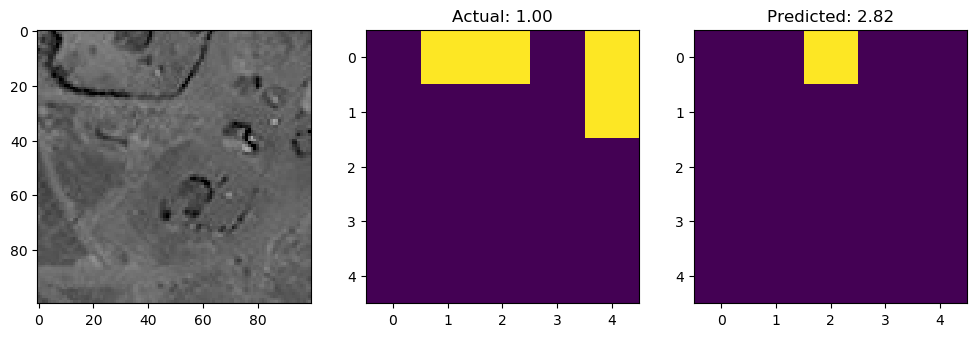

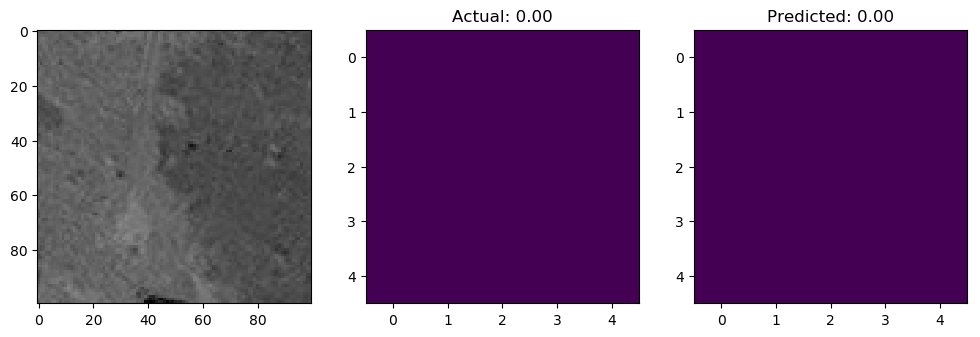

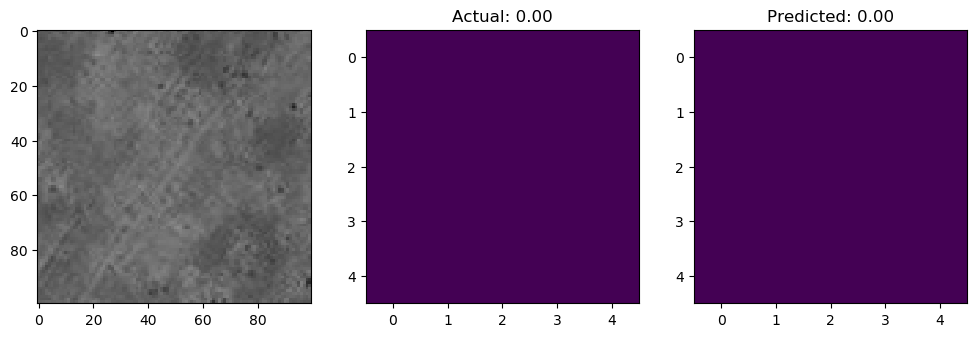

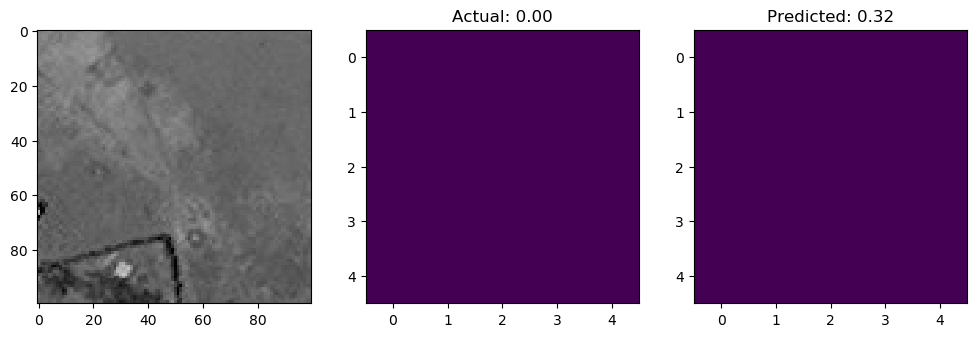

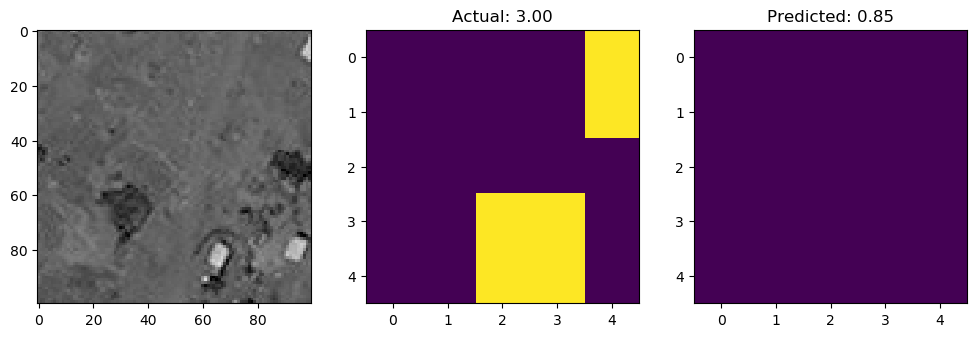

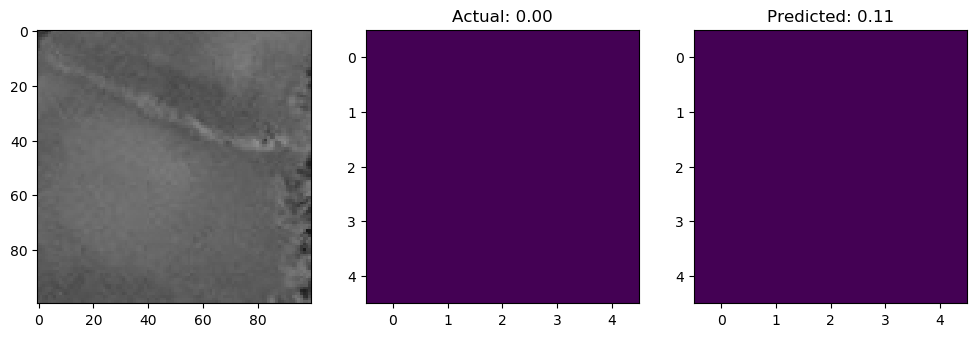

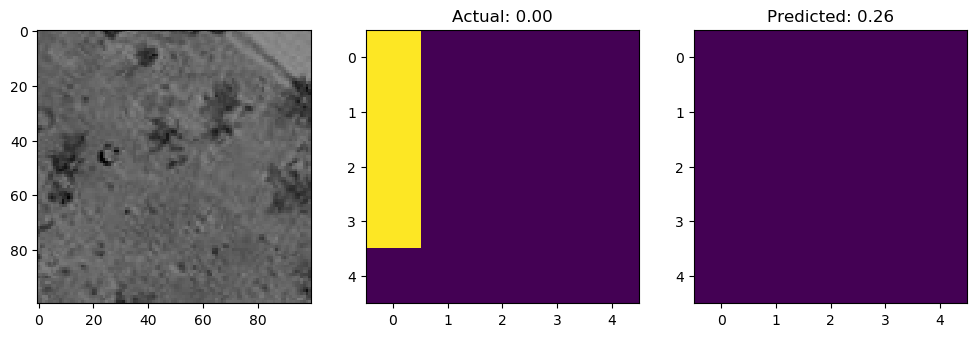

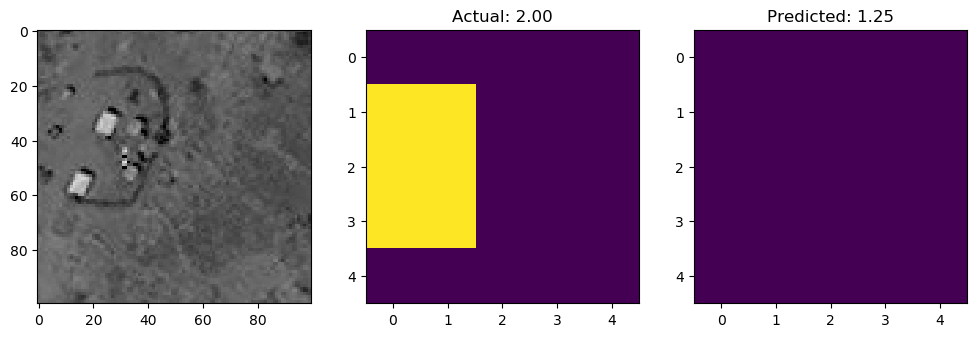

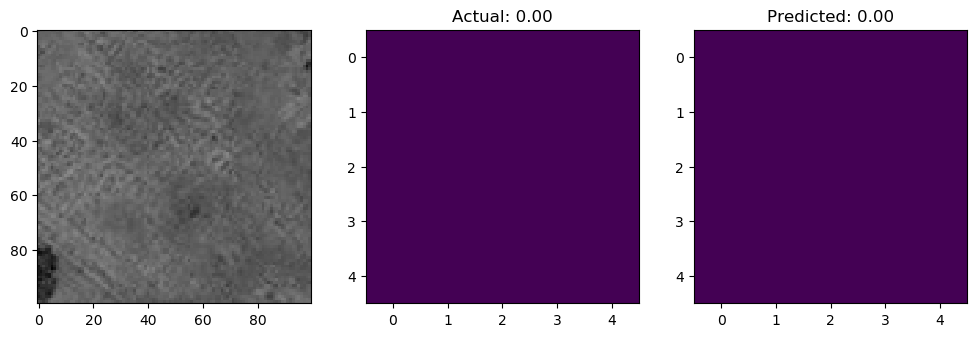

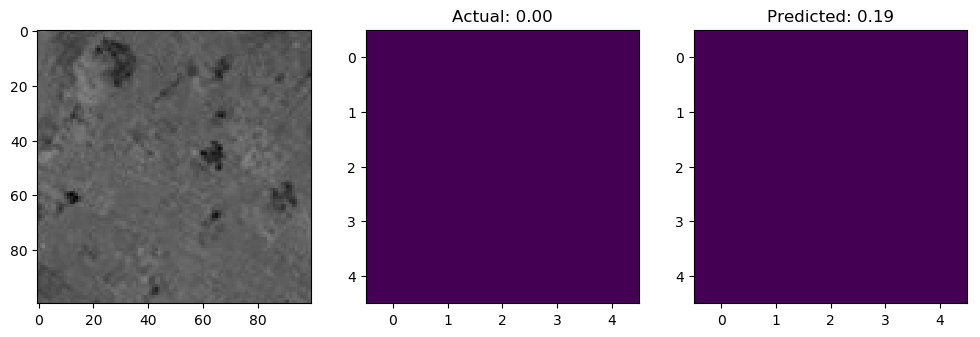

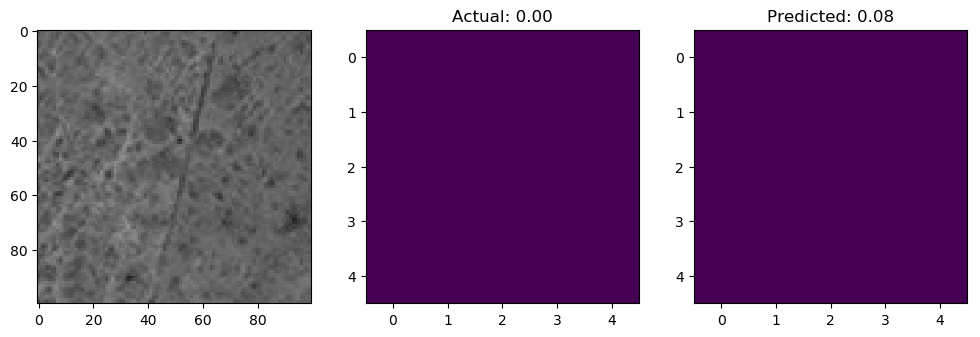

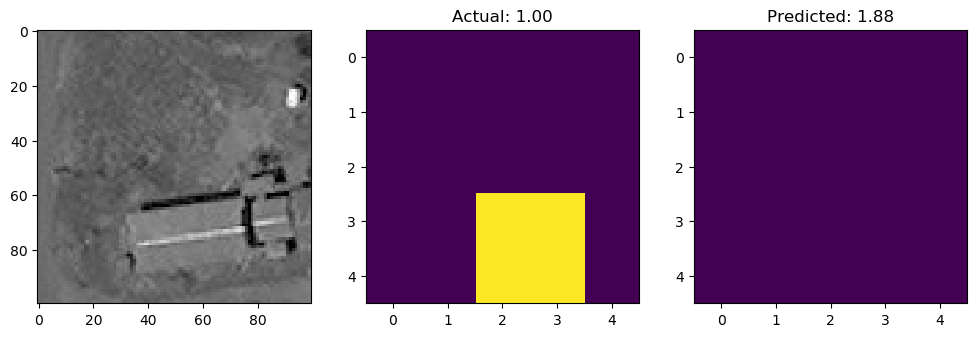

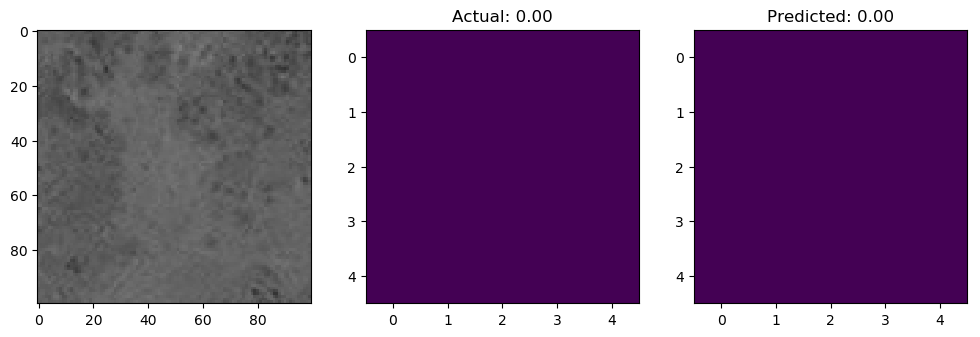

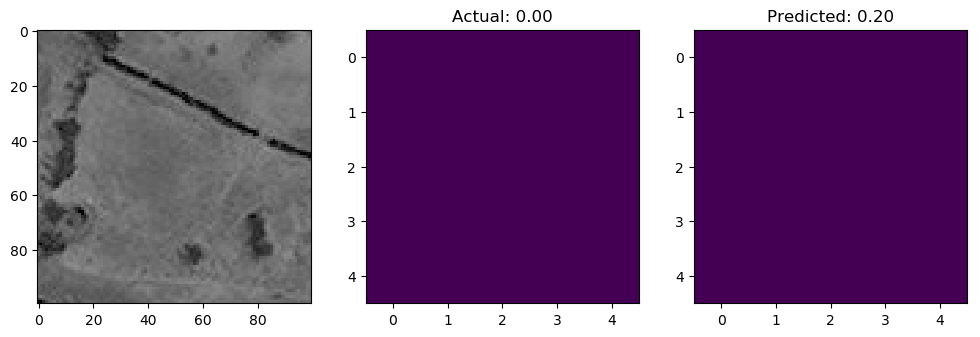

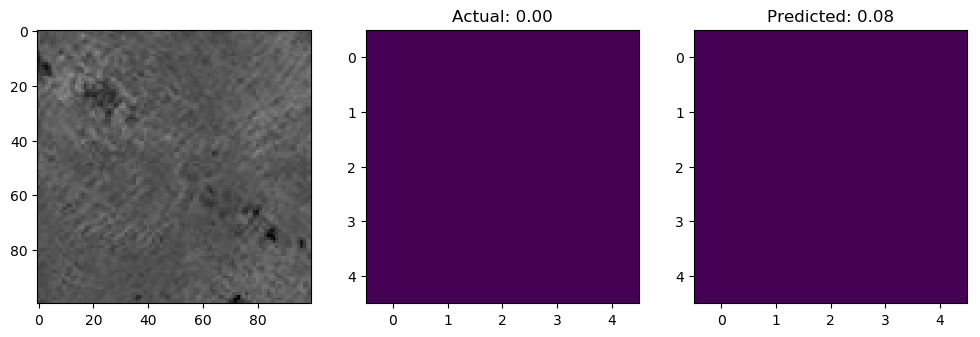

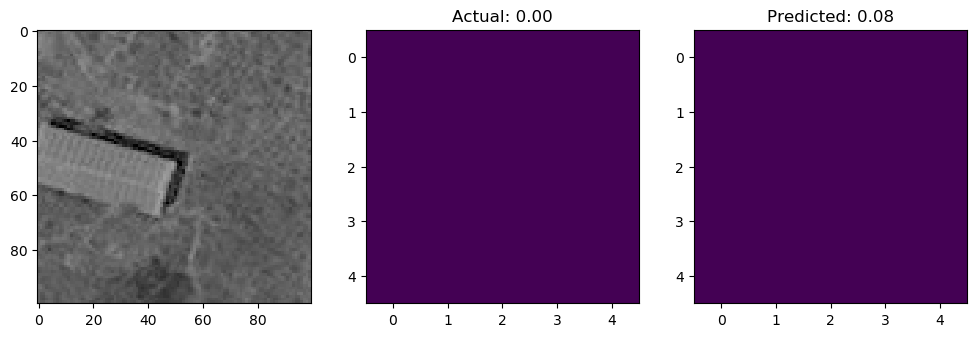

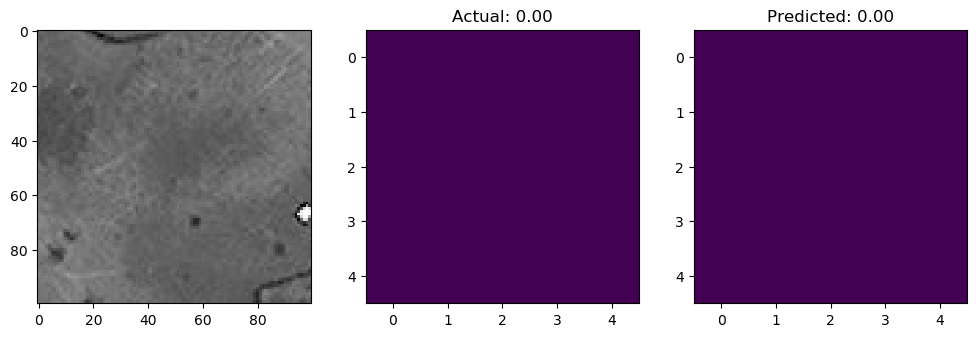

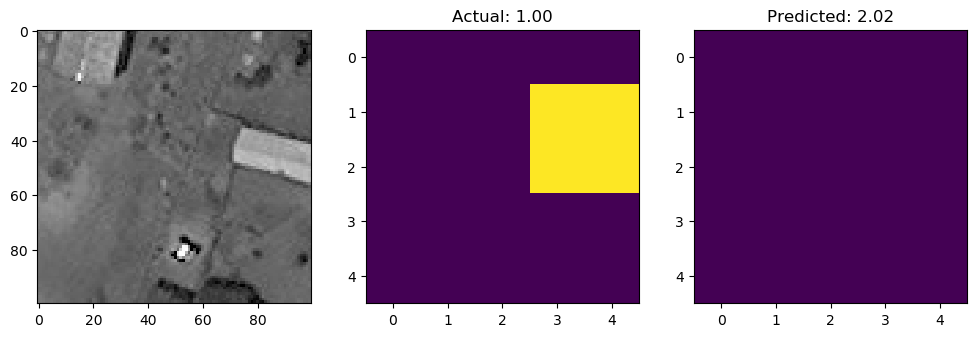

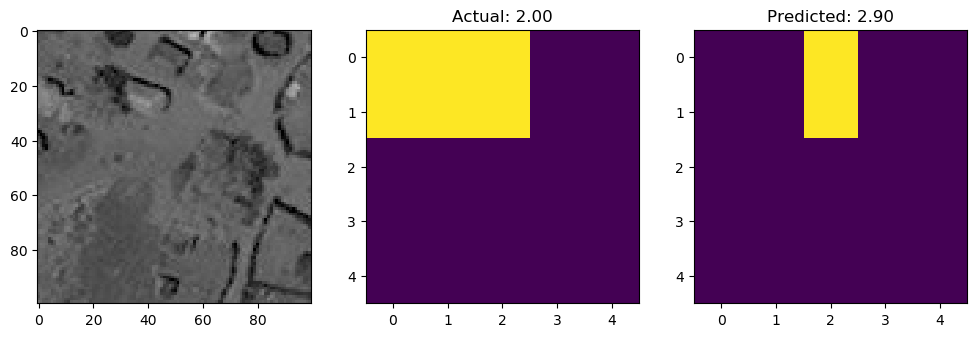

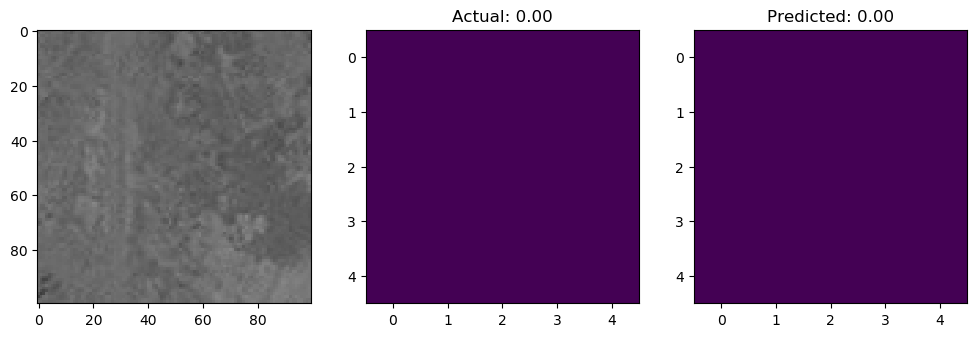

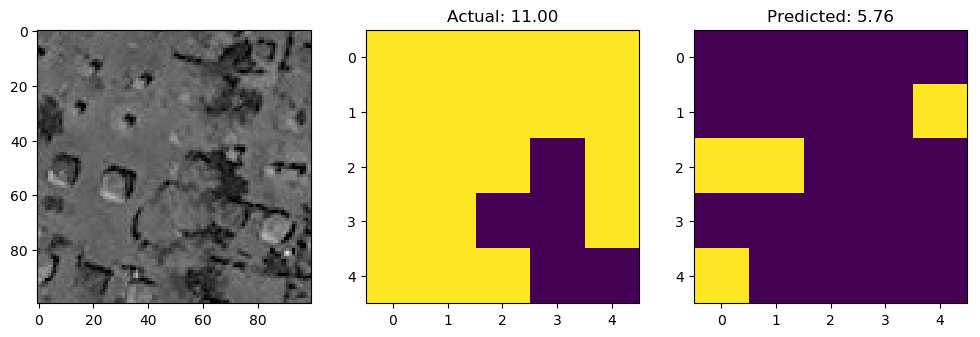

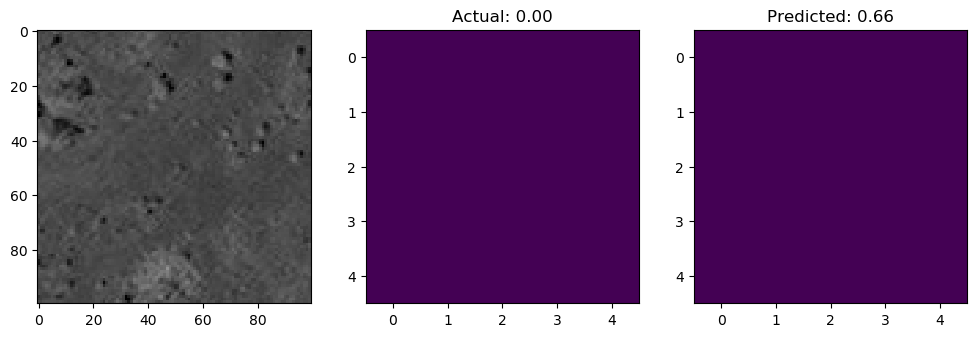

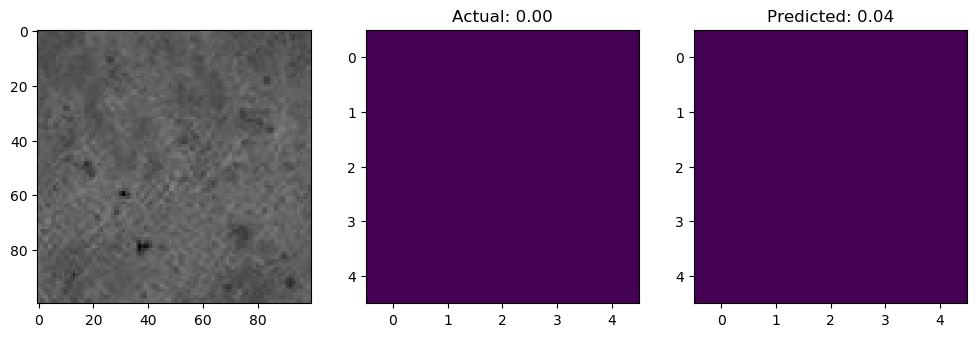

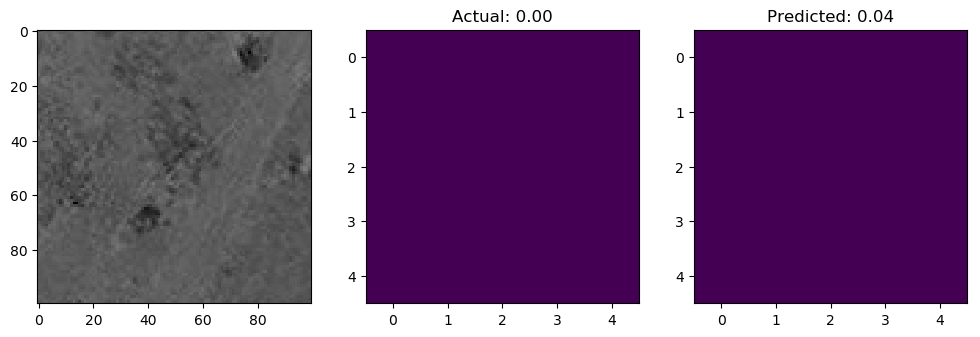

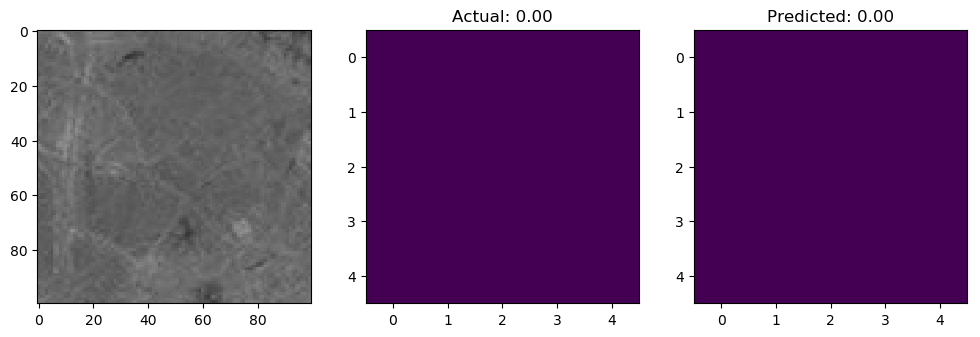

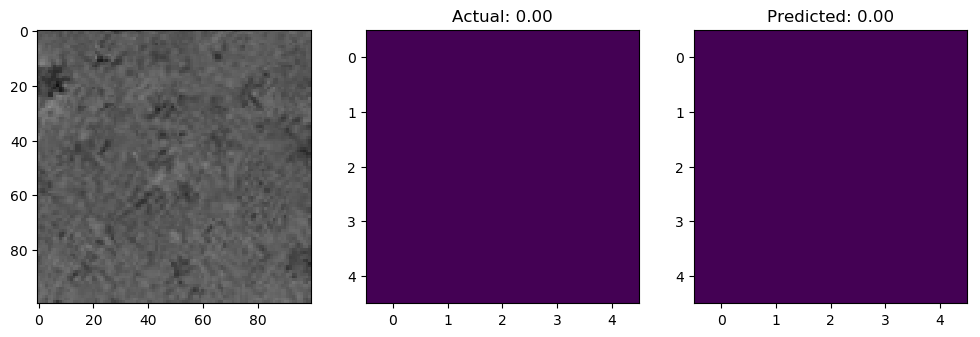

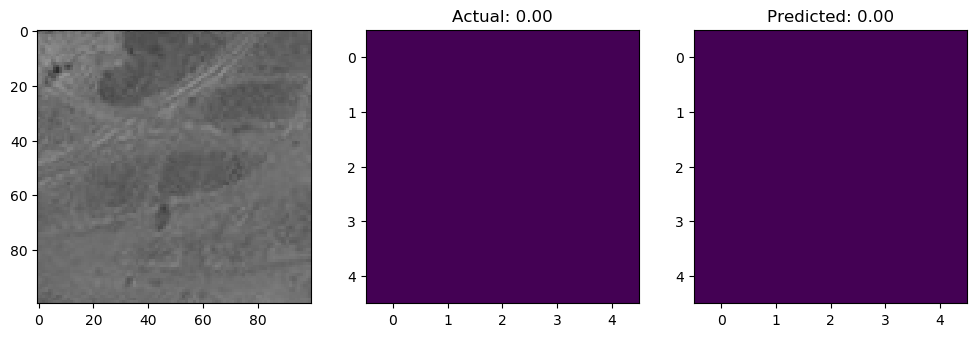

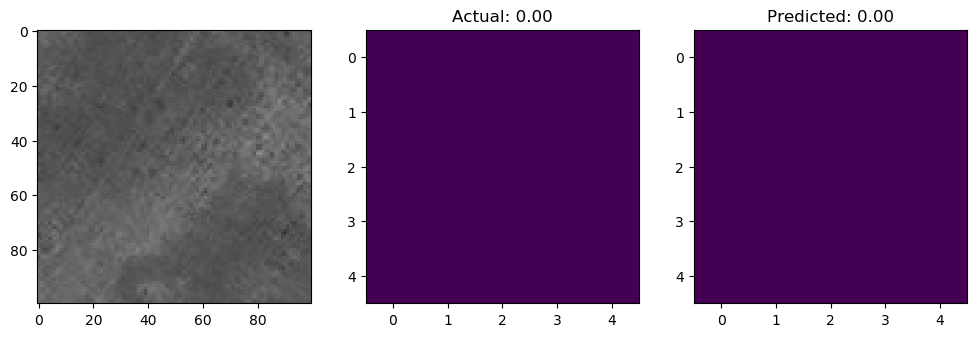

In [54]:
for i in range(20, 50):
    fig=plt.figure(figsize=(3*4, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow((128 + train_images[i]*128).astype(int))
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(train_map_trues[i])
    plt.title('Actual: {0:0.02f}'.format(train_count_trues[i]))
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(train_map_preds[i] > 0.5)
    plt.title('Predicted: {0:0.02f}'.format(train_count_preds[i]))
    plt.show()

# Africa1 Results

In [ ]:
print(list(test_count_preds[:300]))

precision: 0.6226281193647839
recall: 0.23536810625384819
f1: 0.3416024382849028


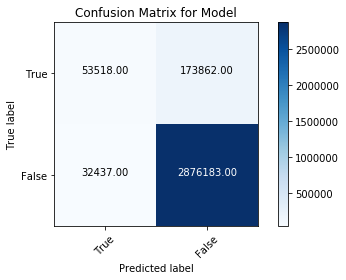

precision: 0.591520665956829
recall: 0.23317752551750454
f1: 0.33449649000369475


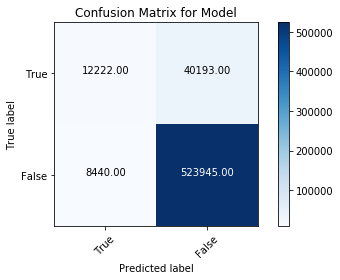

precision: 0.5960698689956332
recall: 0.11098162502032631
f1: 0.18712301224639005


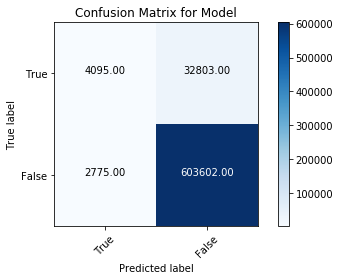

array([[  4095,  32803],
       [  2775, 603602]])

In [39]:
get_cm(train_map_trues, train_map_preds)
get_cm(val_map_trues, val_map_preds)
get_cm(test_map_trues, test_map_preds)

In [40]:
gt_test = [0.0, 6.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 3.0, 2.0, 8.0, 6.0, 0.0, 3.0, 7.0, 0.0, 2.0, 0.0, 5.0, 2.0, 3.0, 1.0, 0.0, 3.0, 0.0, 0.0, 2.0, 4.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 3.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 1.0, 3.0, 1.0, 1.0, 0.0, 0.0, 4.0, 4.0, 6.0, 3.0, 0.0, 0.0, 0.0, 3.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 6.0, 1.0, 5.0, 0.0, 5.0, 4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 4.0, 0.0, 1.0, 4.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 0.0, 0.0, 1.0, 2.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 5.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 4.0, 2.0, 3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 5.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 3.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 3.0, 0.0, 3.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 2.0, 0.0, 6.0, 0.0, 3.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 1.0, 0.0, 4.0, 2.0, 0.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 1.0]

In [44]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

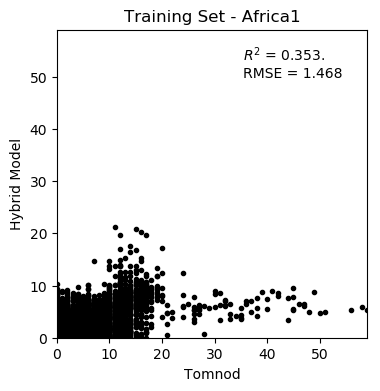

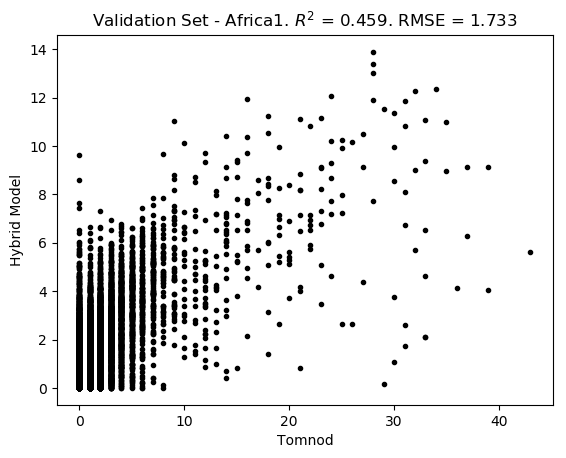

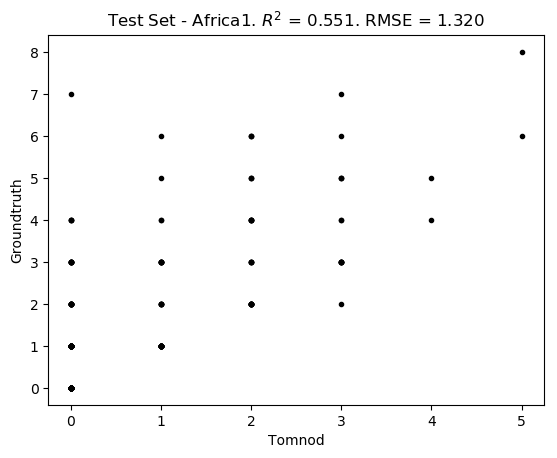

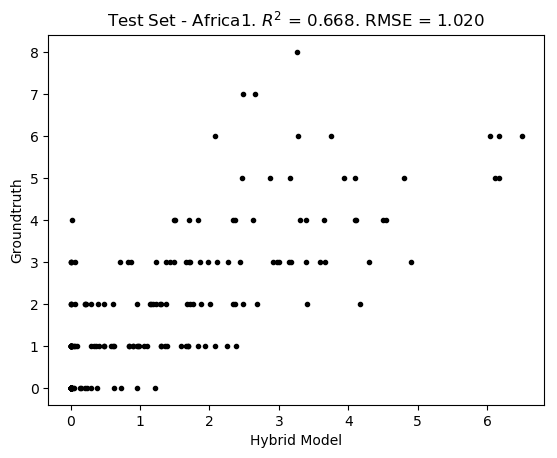

In [59]:
mt, bt, rt, pt, et = stats.linregress(train_count_trues, train_count_preds)
rmse_train = rmse(train_count_trues, train_count_preds)
mv, bv, rv, pv, ev = stats.linregress(val_count_trues, val_count_preds)
rmse_val = rmse(val_count_trues, val_count_preds)

mf, bf, rf, pf, ef = stats.linregress(test_count_trues[:300], gt_test)
rmse_test_cs = rmse(test_count_trues[:300], gt_test)

mf, bf, rm, pf, ef = stats.linregress(test_count_preds[:300], gt_test)
rmse_test_mod = rmse(test_count_preds[:300], gt_test)


fancy_plot(train_count_trues, train_count_preds, 
           'Training Set - Africa1', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(rt**2, rmse_train))

fancy_plot(val_count_trues, val_count_preds, 
           'Validation Set - Africa1', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(rv**2, rmse_val))

fancy_plot(test_count_trues, test_count_preds, 
           'Test Set - Africa1', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(rtest**2, rmse_val))

plt.plot(test_count_trues[:300], gt_test, 'k.')
plt.xlabel('Tomnod')
plt.ylabel('Groundtruth')
plt.title('Test Set - Africa1. $R^2$ = {0:0.03f}. RMSE = {1:0.03f}'.format(rf**2, rmse_test_cs))
plt.show()

plt.plot(test_count_preds[:300], gt_test, 'k.')
plt.xlabel('Hybrid Model')
plt.ylabel('Groundtruth')
plt.title('Test Set - Africa1. $R^2$ = {0:0.03f}. RMSE = {1:0.03f}'.format(rm**2, rmse_test_mod))
plt.show()

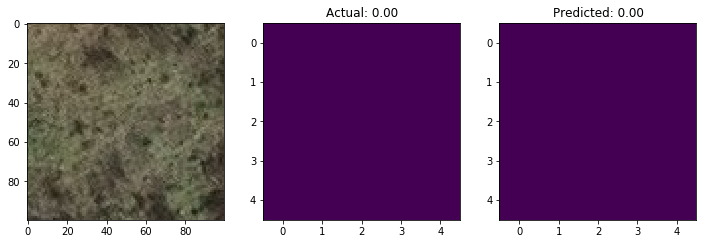

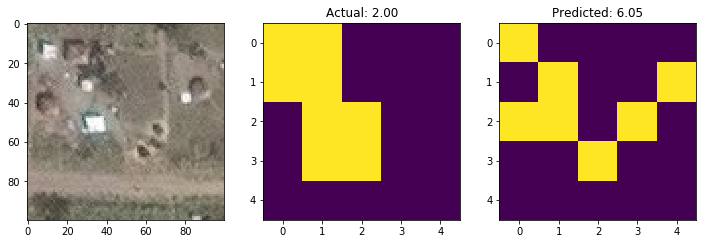

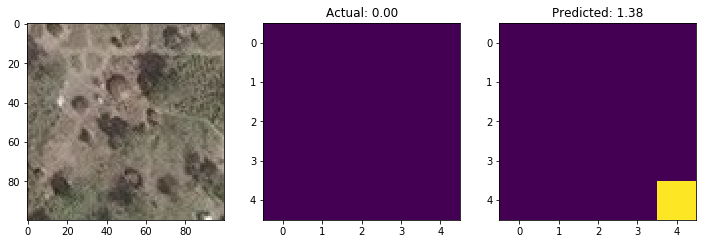

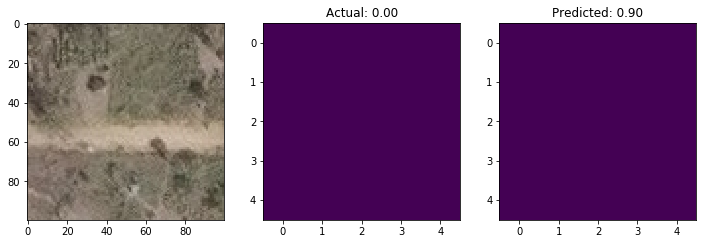

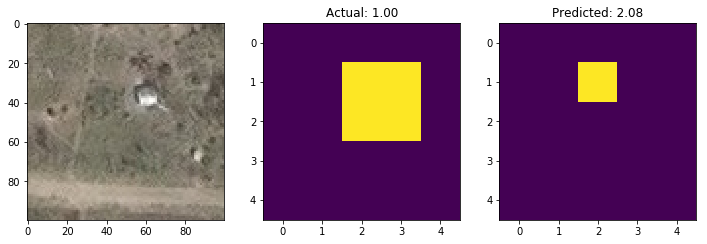

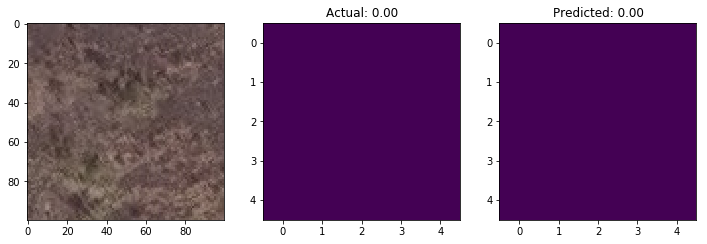

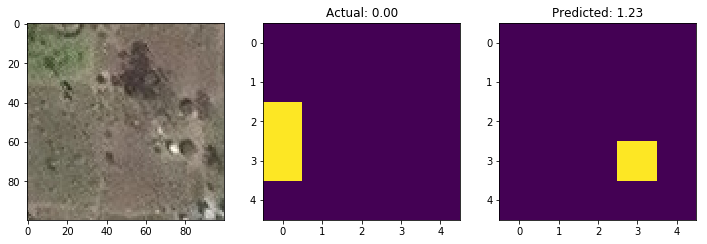

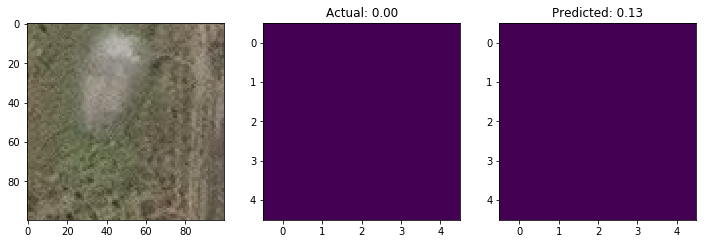

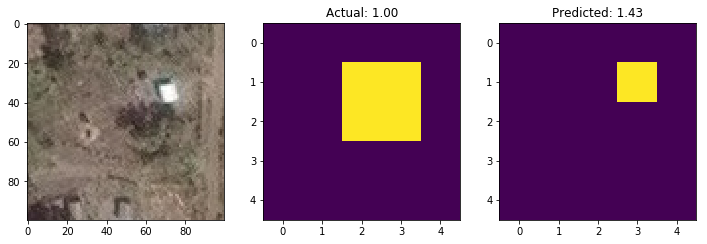

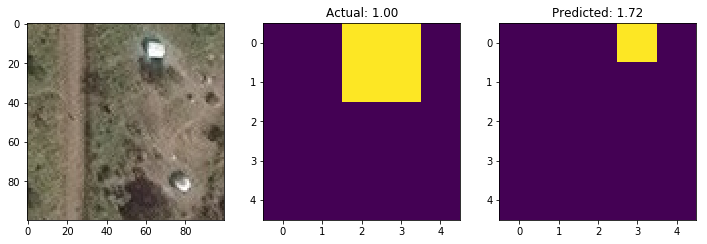

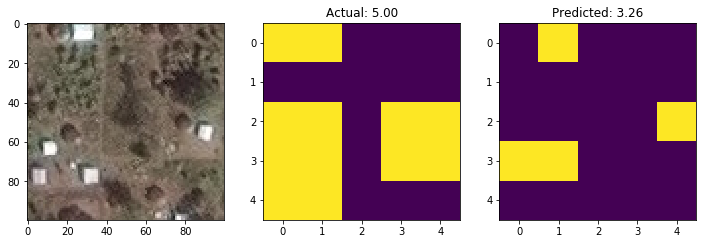

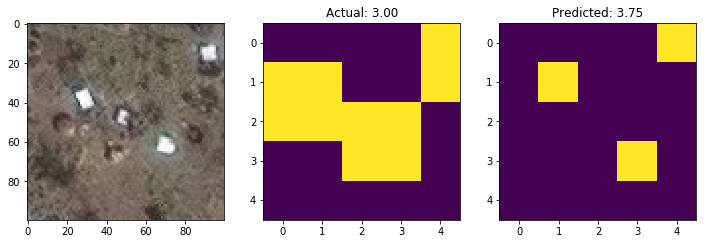

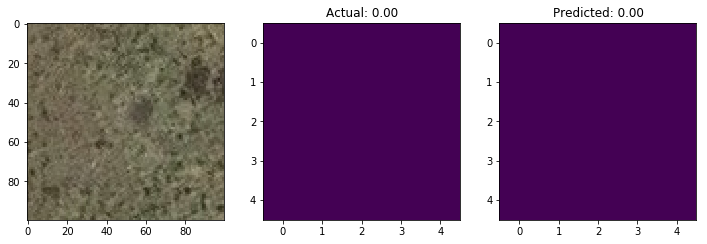

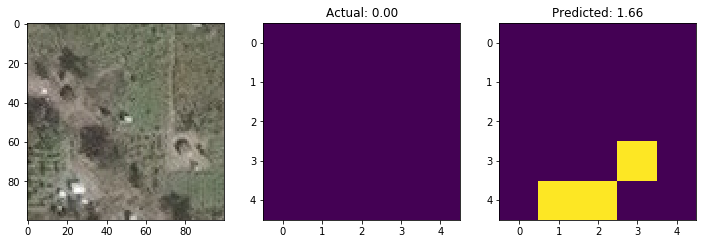

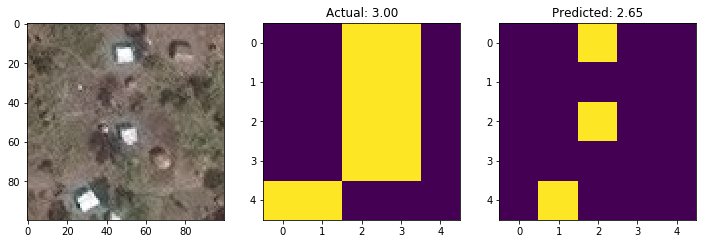

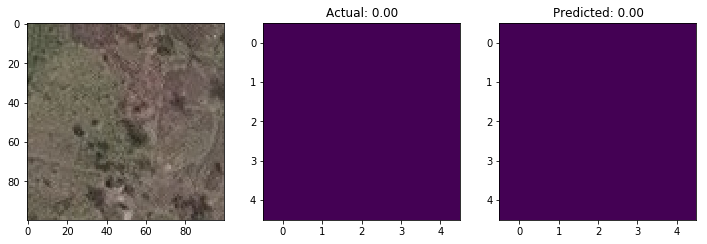

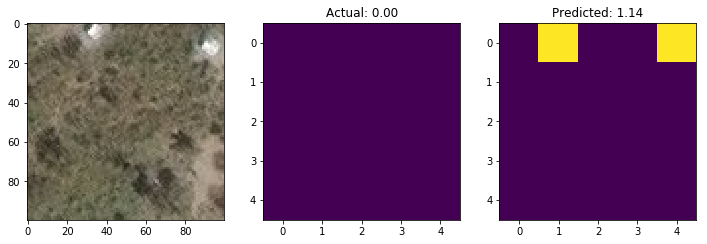

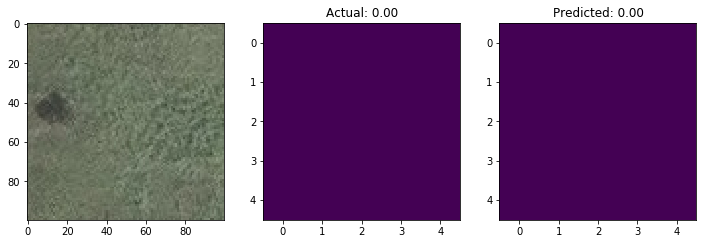

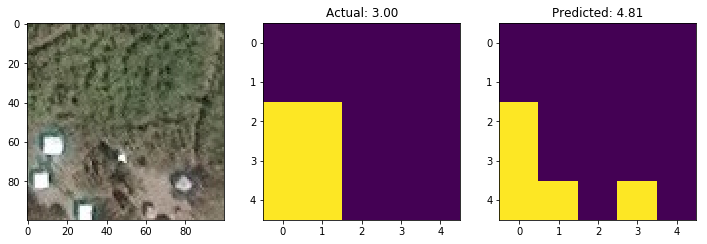

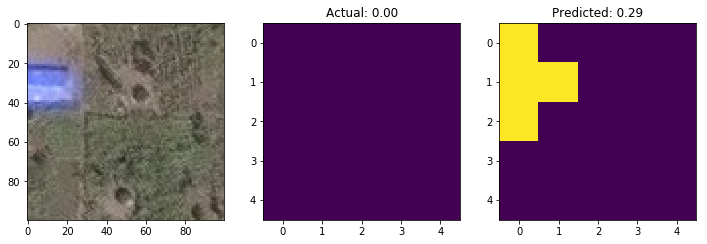

In [42]:
for i in range(20):
    fig=plt.figure(figsize=(3*4, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow((128 + test_images[i]*128).astype(int))
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(test_map_trues[i])
    plt.title('Actual: {0:0.02f}'.format(test_count_trues[i]))
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(test_map_preds[i] > 0.5)
    plt.title('Predicted: {0:0.02f}'.format(test_count_preds[i]))
    plt.show()

# Southwest Asia Results

In [27]:
print(list(test_count_preds[:300]))

[0.9721164, 0.045523684, 0.20749325, 0.7854211, 0.0, 4.367854, 0.43565828, 0.0, 0.0, 2.7426245, 1.5566757, 0.0, 0.0, 0.07629924, 0.0, 0.0008465946, 3.619034, 0.0, 3.5856013, 0.70004445, 0.0, 0.0, 0.47977507, 2.9798274, 1.7037635, 2.9719265, 0.819957, 0.61401874, 2.2849035, 0.0, 0.6414766, 4.1518908, 0.37711728, 0.0, 3.9759543, 1.5710021, 0.0, 0.0, 3.4014254, 0.0, 4.2896614, 4.9466934, 2.1817963, 0.0, 0.0, 4.6789474, 2.9841263, 6.276438, 4.2359586, 0.0, 0.0, 1.8352488, 1.6640465, 2.030817, 1.3277979, 3.2602801, 1.5871725, 2.3264675, 2.5869367, 0.0, 0.0, 5.969669, 4.6206284, 0.0, 1.266566, 1.6041304, 0.0, 3.497746, 4.7853603, 1.3774862, 4.168485, 0.45867723, 1.8974698, 0.0, 0.71878356, 0.0, 2.2990098, 0.0, 7.039292, 4.8775935, 5.319972, 0.3762177, 0.0, 0.0, 0.0, 0.0, 1.3250611, 0.0, 0.0, 1.1958346, 0.66613686, 0.0, 1.1001853, 0.0, 0.0, 0.0, 0.0, 1.9239969, 0.13147503, 1.6598023, 0.97462606, 0.0, 0.37573895, 0.0, 0.0, 4.4044247, 2.2010102, 1.3339835, 2.198315, 0.47580957, 0.0, 0.12577638,

precision: 0.6868846002363135
recall: 0.5622783449758194
f1: 0.6183666233305756


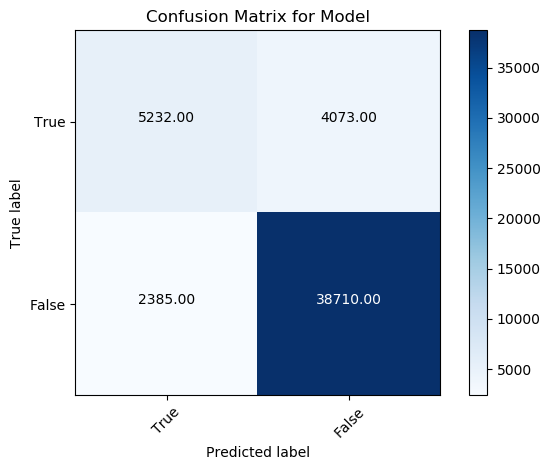

precision: 0.10938712179984485
recall: 0.06444241316270567
f1: 0.08110440034512512


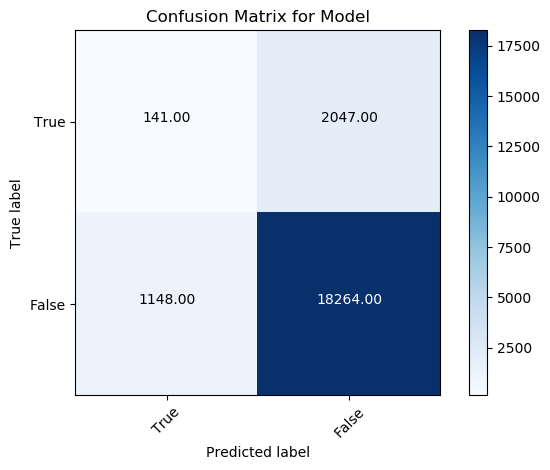

precision: 0.10589519650655022
recall: 0.08482728465238304
f1: 0.09419762078174314


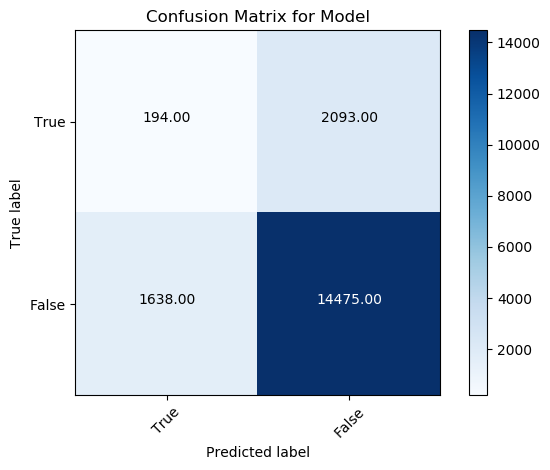

array([[  194,  2093],
       [ 1638, 14475]])

In [28]:
get_cm(train_map_trues, train_map_preds)
get_cm(val_map_trues, val_map_preds)
get_cm(test_map_trues, test_map_preds)

In [29]:
gt_test = [2.0, 12.0, 0.0, 0.0, 13.0, 9.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 0.0, 14.0, 0.0, 2.0, 8.0, 0.0, 4.0, 19.0, 0.0, 1.0, 0.0, 9.0, 5.0, 4.0, 0.0, 0.0, 7.0, 0.0, 4.0, 5.0, 16.0, 0.0, 6.0, 7.0, 0.0, 23.0, 5.0, 0.0, 4.0, 16.0, 5.0, 0.0, 3.0, 10.0, 2.0, 3.0, 9.0, 0.0, 0.0, 6.0, 0.0, 5.0, 0.0, 22.0, 4.0, 7.0, 9.0, 0.0, 0.0, 7.0, 13.0, 1.0, 0.0, 0.0, 2.0, 4.0, 4.0, 2.0, 7.0, 23.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 11.0, 7.0, 14.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 5.0, 0.0, 11.0, 0.0, 1.0, 7.0, 0.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 10.0, 6.0, 2.0, 12.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 14.0, 7.0, 2.0, 2.0, 0.0, 2.0, 0.0, 8.0, 0.0, 0.0, 0.0, 1.0, 0.0, 7.0, 2.0, 12.0, 0.0, 0.0, 1.0, 3.0, 0.0, 16.0, 8.0, 0.0, 12.0, 2.0, 1.0, 5.0, 8.0, 0.0, 0.0, 1.0, 1.0, 12.0, 12.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 8.0, 5.0, 6.0, 0.0, 0.0, 6.0, 0.0, 8.0, 10.0, 0.0, 0.0, 12.0, 0.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 10.0, 3.0, 4.0, 3.0, 12.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 12.0, 6.0, 15.0, 16.0, 2.0, 6.0, 12.0, 13.0, 14.0, 0.0, 9.0, 17.0, 1.0, 16.0, 0.0, 6.0, 0.0, 4.0, 2.0, 1.0, 13.0, 10.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 8.0, 0.0, 0.0, 12.0, 14.0, 13.0, 4.0, 0.0, 0.0, 8.0, 2.0, 0.0, 3.0, 1.0, 8.0, 1.0, 0.0, 0.0, 0.0, 15.0, 0.0, 1.0, 13.0, 0.0, 11.0, 6.0, 0.0, 0.0, 3.0, 0.0, 1.0, 8.0, 0.0, 3.0, 0.0, 0.0, 10.0, 14.0, 0.0, 0.0, 0.0, 3.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 3.0, 5.0, 0.0, 0.0, 2.0, 2.0, 13.0, 0.0, 4.0, 1.0, 6.0, 1.0, 0.0, 0.0, 1.0, 8.0, 6.0, 0.0, 0.0, 16.0, 2.0, 0.0, 12.0, 0.0, 5.0, 2.0, 2.0, 10.0]

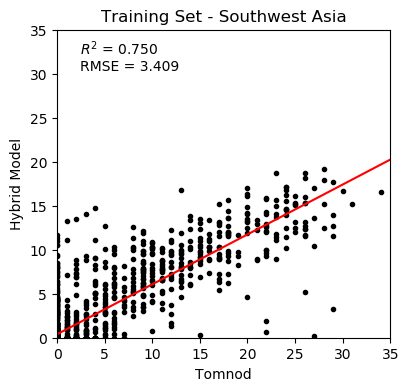

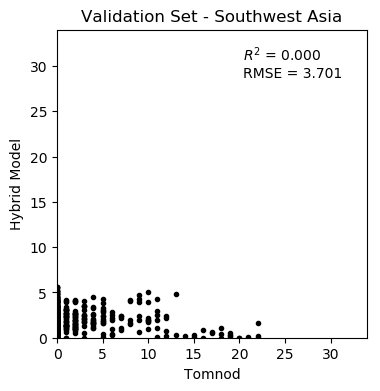

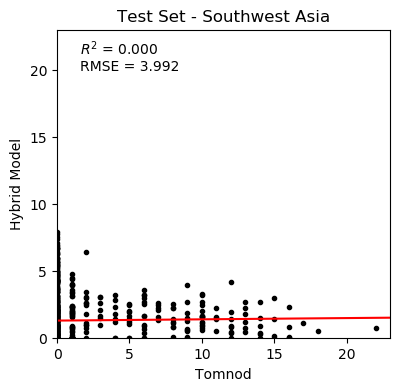

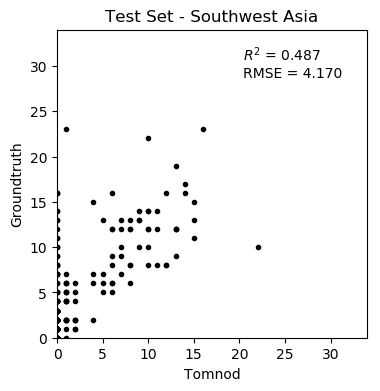

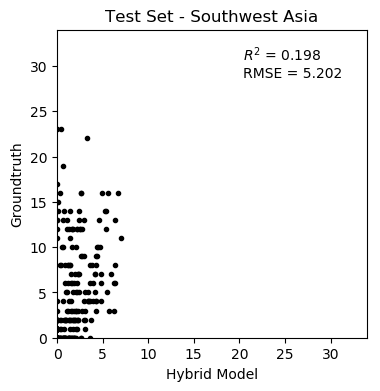

In [49]:
mt, bt, rt, pt, et = stats.linregress(train_count_trues, train_count_preds)
rmse_train = rmse(train_count_trues, train_count_preds)

mv, bv, rv, pv, ev = stats.linregress(val_count_trues, val_count_preds)
rmse_val = rmse(val_count_trues, val_count_preds)

mv, bv, rtest, pv, ev = stats.linregress(test_count_trues, test_count_preds)
rmse_test = rmse(test_count_trues, test_count_preds)

mf, bf, rf, pf, ef = stats.linregress(test_count_trues[:300], gt_test)
rmse_test_cs = rmse(test_count_trues[:300], gt_test)

mf, bf, rm, pf, ef = stats.linregress(test_count_preds[:300], gt_test)
rmse_test_mod = rmse(test_count_preds[:300], gt_test)

show_correlations(train_count_trues, train_count_preds, 
           'Training Set - Southwest Asia', 'Tomnod', 'Hybrid Model')

fancy_plot(val_count_trues, val_count_preds, 
           'Validation Set - Southwest Asia', 'Tomnod', 'Hybrid Model', 
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rv**2, rmse_val))

show_correlations(test_count_trues, test_count_preds, 
           'Test Set - Southwest Asia', 'Tomnod', 'Hybrid Model')

fancy_plot(test_count_trues[:300], gt_test,
          'Test Set - Southwest Asia', 'Tomnod', 'Groundtruth',
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rf**2, rmse_test_cs))

fancy_plot(test_count_preds[:300], gt_test,
          'Test Set - Southwest Asia', 'Hybrid Model', 'Groundtruth',
          '$R^2$ = {0:0.03f}\nRMSE = {1:0.03f}'.format(rm**2, rmse_test_mod))

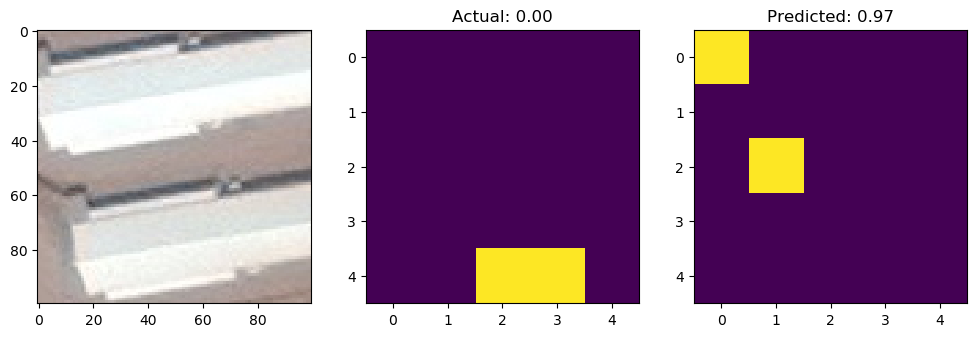

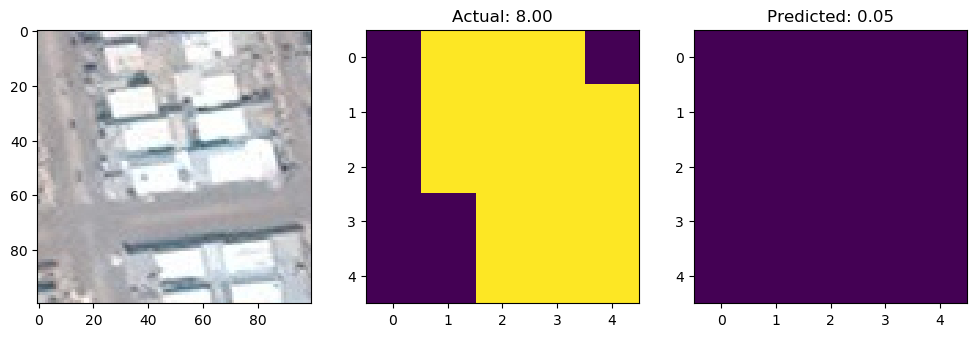

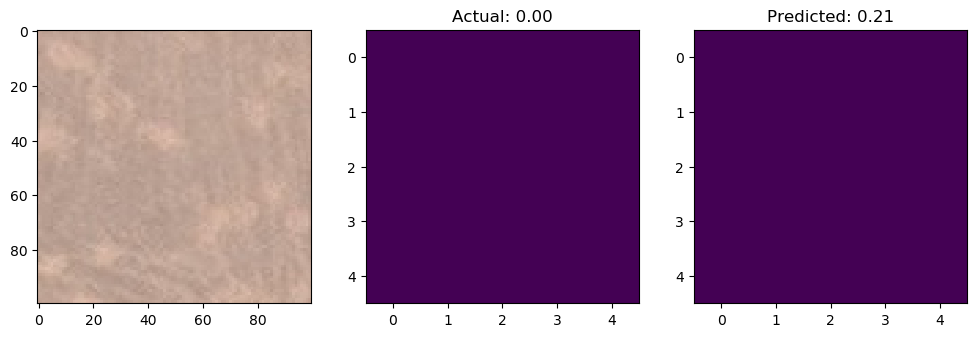

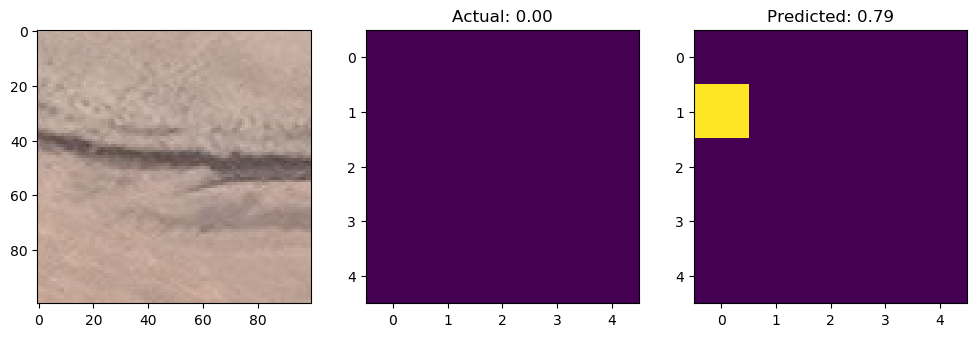

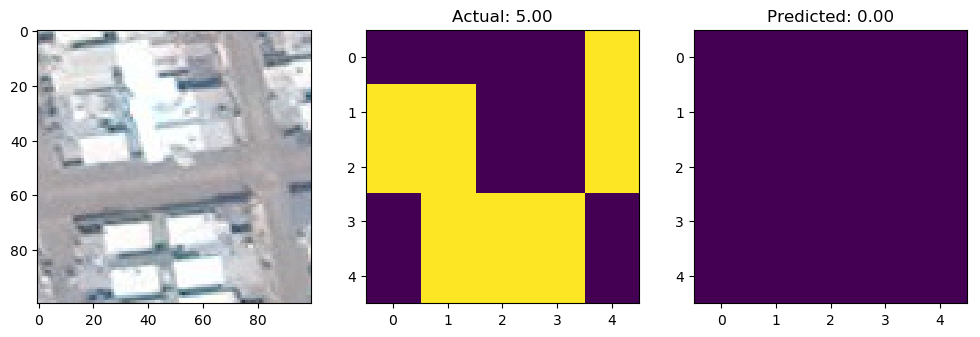

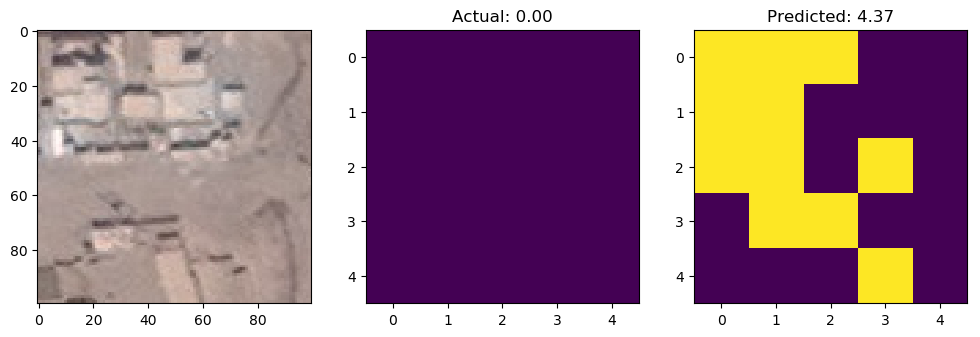

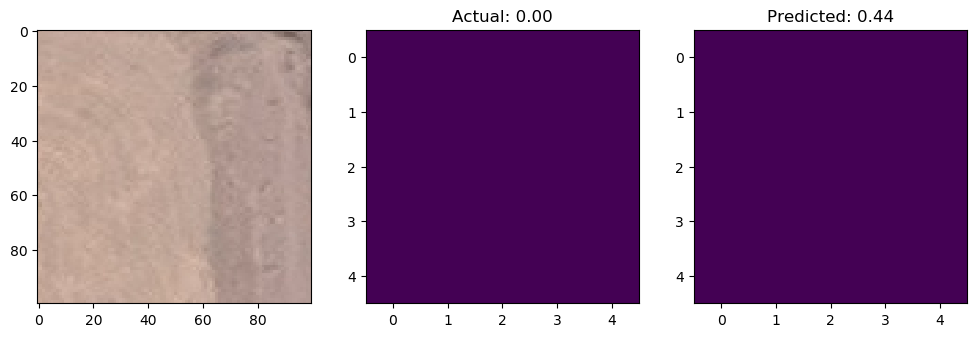

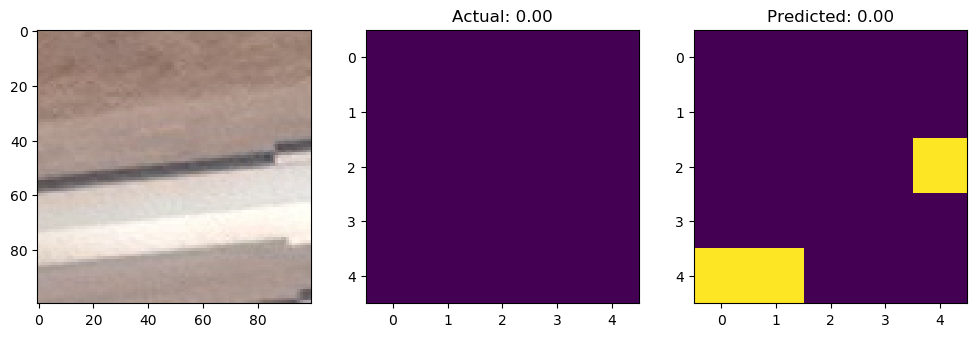

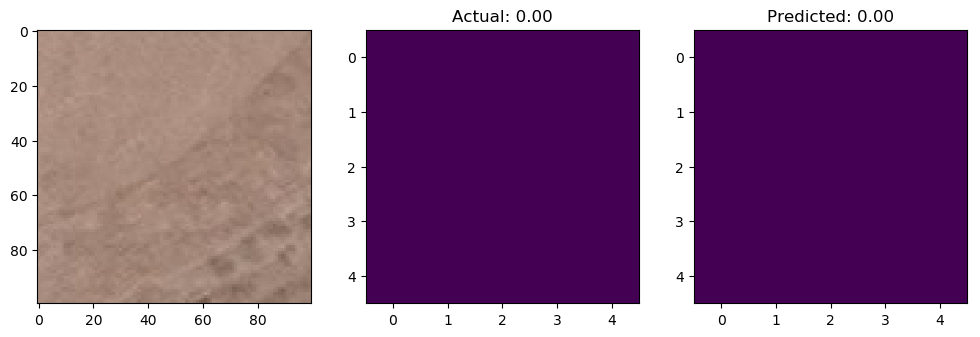

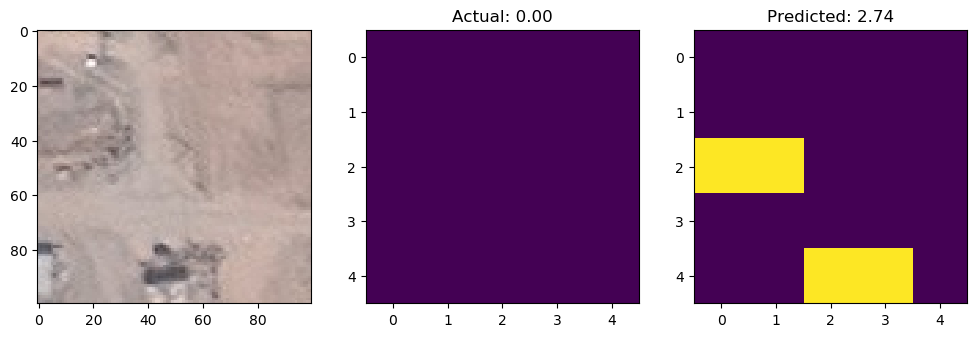

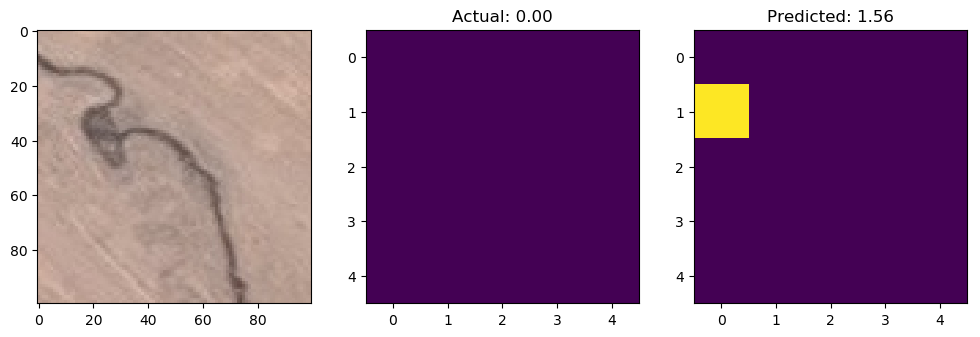

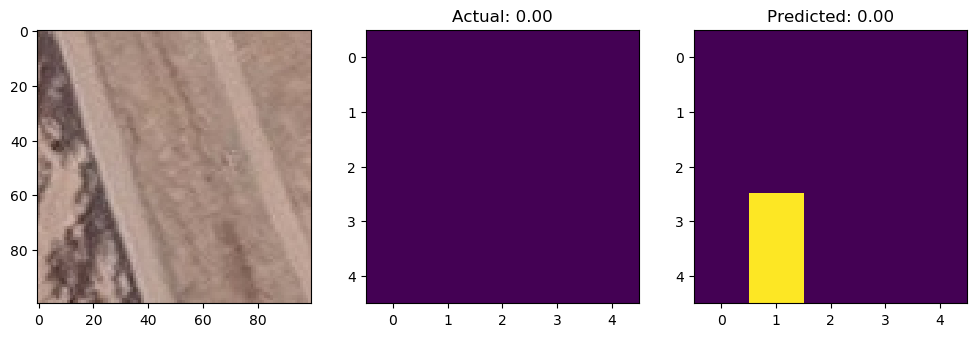

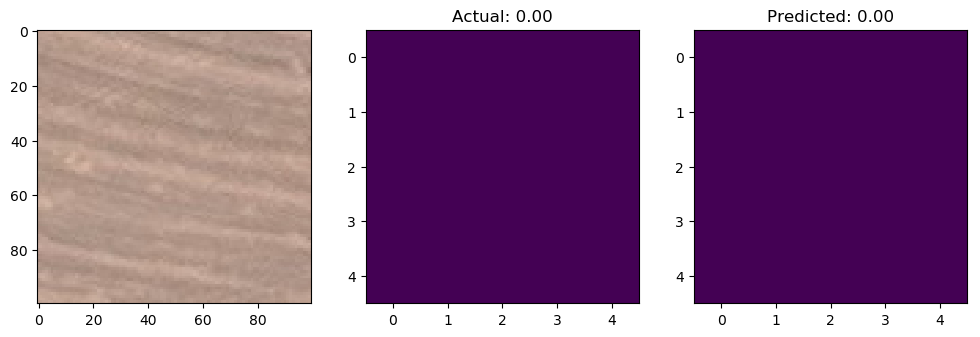

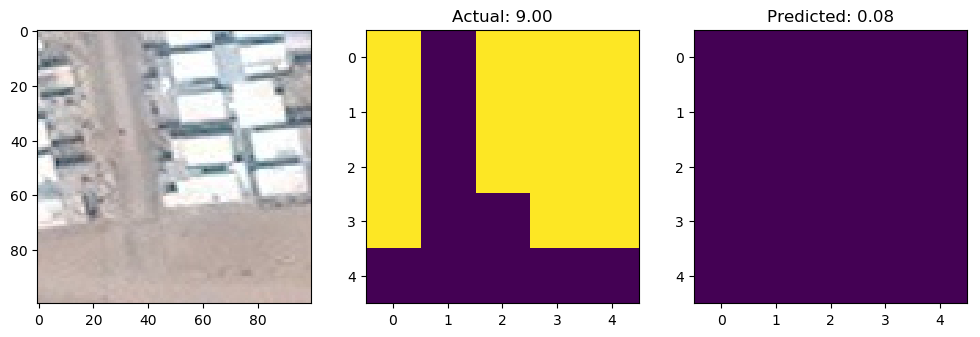

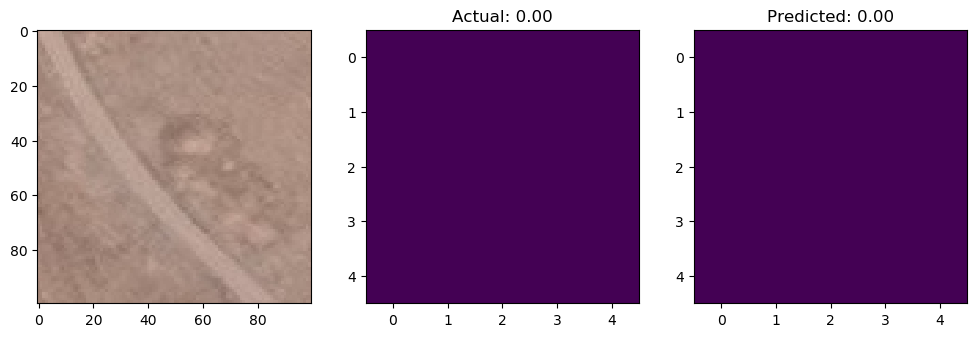

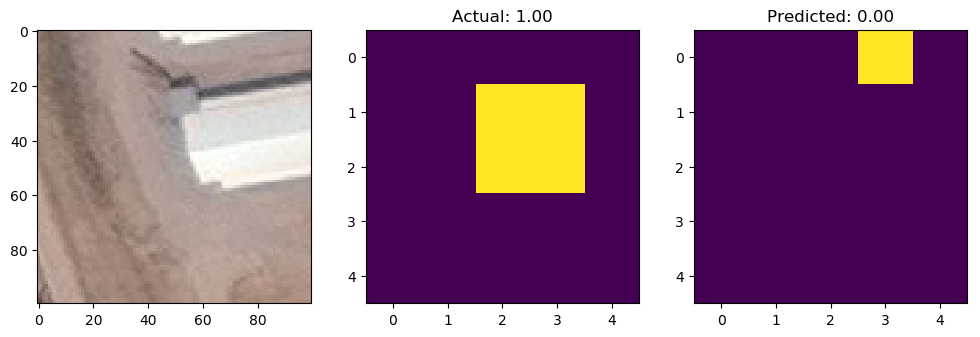

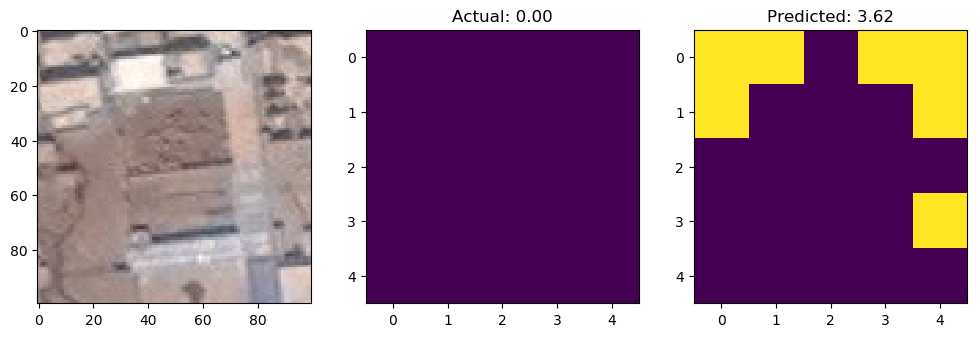

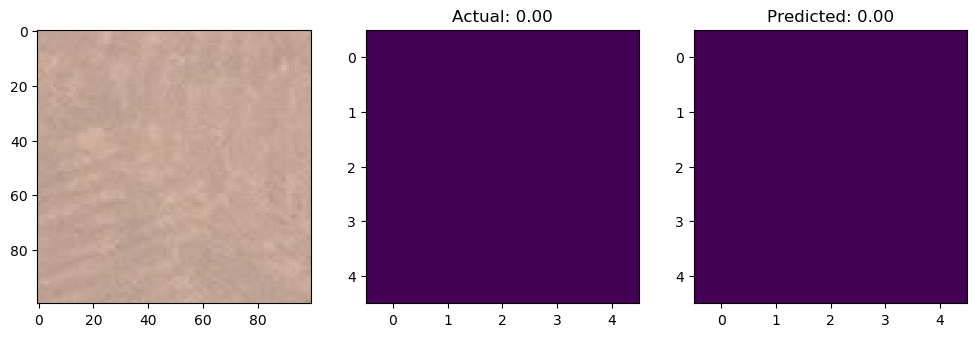

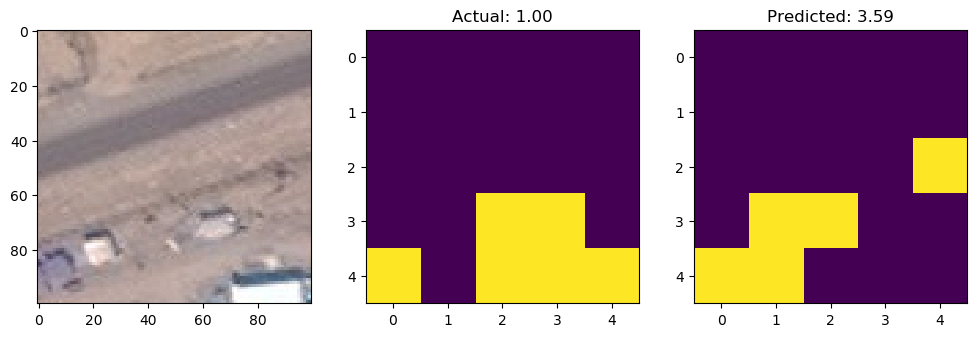

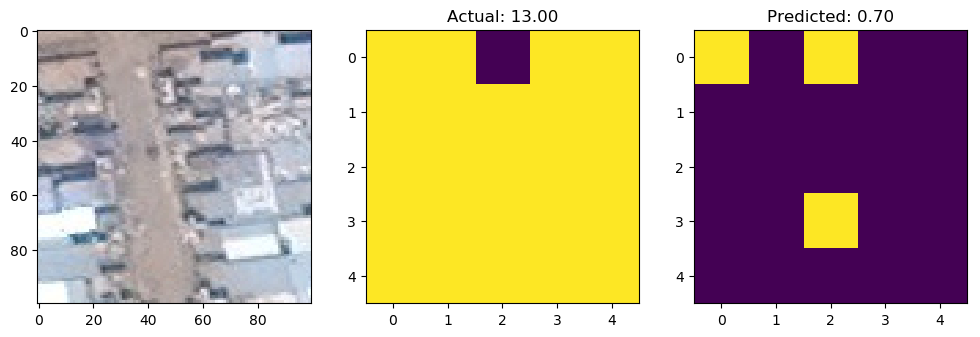

In [32]:
for i in range(20):
    fig=plt.figure(figsize=(3*4, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow((128 + test_images[i]*128).astype(int))
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(test_map_trues[i])
    plt.title('Actual: {0:0.02f}'.format(test_count_trues[i]))
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(test_map_preds[i] > 0.5)
    plt.title('Predicted: {0:0.02f}'.format(test_count_preds[i]))
    plt.show()